In [41]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import stats
from scipy.interpolate import UnivariateSpline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from matplotlib.animation import FuncAnimation
import scipy.stats as stats
from IPython.display import Image

# Excercise 1 (Lattice methods)

### a) **Compute and visualize the $Cox-Ross-Rubinstein$ binomial tree (without dividends) of the underlying, the European call and put and the American call and put**

Let's start by creating a function that creates the Cox-Ross-Rubenstein binomial tree of the underlying. $Cox-Ross-Rubinstein$ tree has the following characteristics:
$$u=e^{\sigma \sqrt{\Delta t}} \qquad d = 1/u $$
$$S(t=n\Delta t,k)=S_0u^{k}d^{n-k}$$
where $n$ is the number of steps and $k$ is the number of up events. 
We furtherly create a function that allows to visualize any binomial tree. 

In [42]:
def binomial_tree(S_0: float,
                  sigma: float,
                  T: int,
                  steps: float):
    
    ''' 
    creates a tree CRR organized as a dictionary where the key is the tuple (t,k) 
    identifying the node and the value is the state (price) of the process in that node.
    OUTPUT: tree: dict {(t,k): price} 
    '''

    dt = T/steps
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    tree = {}
    for i in range(steps + 1):  
        for j in range(i + 1):  
            price= S_0 * (u ** j) * (d ** (i - j))
            tree[(i, j)] = price
    return tree 

def visualize_binomial_tree(tree: dict,
                            x_axis: str, 
                            title = "Binomial Tree"):
                            
    ''' 
    visualize the binomial tree using the real distances. 
    '''
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pos = {}
    labels = {}

    #  set the postion of the nodes
    for (t, j), price in tree.items():
        x = t  # time on the  x axis
        y = price  # price on the y axis
        pos[(t, j)] = (x, y)
        labels[(t, j)] = f"{price:.2f}"

    # draw the nodes
    for (t, j), (x, y) in pos.items():
        ax.plot(x, y, 'o', color='lightblue')
        ax.text(x, y, labels[(t, j)], ha='center', va='bottom', fontsize=8)
    
    max_t = max(k[0] for k in tree.keys())


    # draw the archs 
    for (t, j) in tree:
        if t < max_t:
            for k in [0, 1]:
                node = (t + 1, j + k)
                if node in pos:
                    x_vals = [pos[(t, j)][0], pos[node][0]]
                    y_vals = [pos[(t, j)][1], pos[node][1]]
                    ax.plot(x_vals, y_vals, 'k-')

    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Time steps", fontsize=12)
    ax.set_ylabel(x_axis, fontsize=12)
    plt.grid(True, linestyle='--', alpha= 0.5)
    plt.tight_layout()
    plt.show()


We now need to create the tree of the European Option and the American Option. We start with the European Option and we follow the standard $ backward \ recursion $ using the *binomial_tree* function defined above. In particular in **backward recursion** we fix the value of the last node as:
$$ V(T,k) = max\Big(\phi(S(T,k)-K),0\Big) $$
where $\phi=1$ for calls and $\phi = -1$ for puts. We compute the rest of the tree recursively using:
$$ V(t=n\Delta t,k) = e^{-r\Delta t} \mathbb E\Big[ V(t=(n+1)\Delta t,k+1)q_{up} + V(t=(n+1)\Delta t,k)(1-q_{up})\Big]$$
where:
$$ q_{up} = \frac{e^{r\Delta t}-d}{u-d} $$

In [43]:
def EuropeanOptionTree(S_0: float, 
                       r: float, 
                       sigma: float,
                       T: int,
                       steps: int,
                       K: float, call=False):
     
    ''' 
    defines the tree of the European Option 
    OUTPUT: Europeantree: dict {(t,k): option value} 
    '''

    dt = T/steps
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    a = np.exp(r * dt)
    q = (a - d) / (u - d) 
    tree = binomial_tree(S_0, sigma, T, steps)
    
    EuropeanTree = {}
    
    # Terminal payoffs
    for j in range(steps + 1):
        ST = tree[(steps, j)]
        EuropeanTree[(steps, j)] = max(ST - K, 0) if call==True else max(K - ST, 0)

    
    # Backward induction
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            expected = q * EuropeanTree[(i + 1, j + 1)] + (1 - q) * EuropeanTree[(i + 1, j)]
            EuropeanTree[(i, j)] = expected / a  # discounting 
    
    return EuropeanTree  



We now create the American Option tree, we thus follow the backward recursion as in the European case but we set the node price to the maximum of the $Continuation\ Value$ (the value of keeping the option alive for another time-step) and the $ Immediate \ Payoff $, in order to take care of possible early exercise:
$$ CV(t,k) = e^{-r\Delta t} \mathbb E\Big[ V_{AM}(t=(n+1)\Delta t,k+1)q_{up} + V_{AM}(t=(n+1)\Delta t,k)(1-q_{up})\Big]$$
$$ V_{AM}(t,k) = max\Big(CV(t,k),\text{payoff(t,k)}\Big)

In [44]:
def AmericanOptionTree(S_0: float,
                       r: float,
                       sigma: float,
                       T: int,
                       steps: int, 
                       K: float,
                       call=False):
    
    ''' 
    defines the tree of the American Option
    OUTPUT: AmericanTree: dict {(t,k): option value} 
    '''
    
    dt = T/steps
    u = np.exp(sigma*np.sqrt(dt))
    d = 1/u
    AmericanTree={}
    a = np.exp(r * dt)
    q = (a - d) / (u - d)
    tree=binomial_tree(S_0,sigma,T,steps)
    
    # Terminal payoffs
    for j in range(steps + 1):
        ST = tree[(steps, j)]
        AmericanTree[(steps, j)] = max(ST - K, 0) if call==True else max(K - ST, 0)

    # Backward induction with early exercise
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            expected = q * AmericanTree[(i + 1, j + 1)] + (1 - q) * AmericanTree[(i + 1, j)]
            continuation = expected / a
            immediate_payoff= max(tree[(i, j)] - K, 0) if call else max(K - tree[(i, j)], 0)
            AmericanTree[(i, j)] = max(continuation, immediate_payoff) # check for early exercise

    return AmericanTree



### Implementation
we plot the Underlying tree, the ATM European put option tree and the ATM American put option tree. 

In [45]:
# set up the parameters
S_0 = 100
K = 100
T = 1
steps = 15
r = 0.04
sigma = 0.2

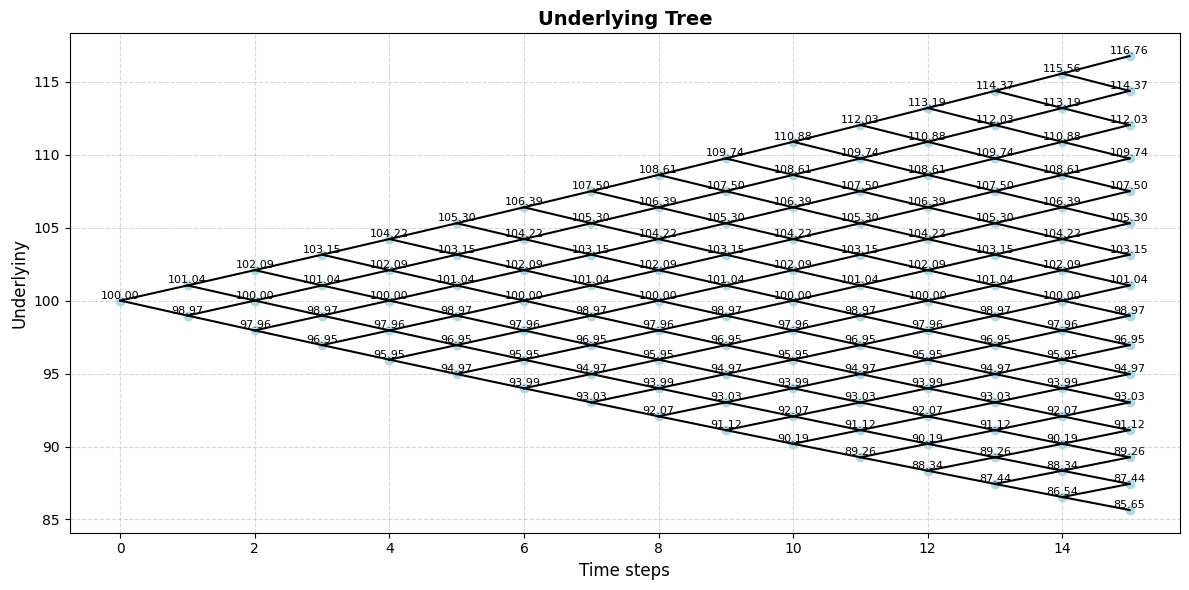

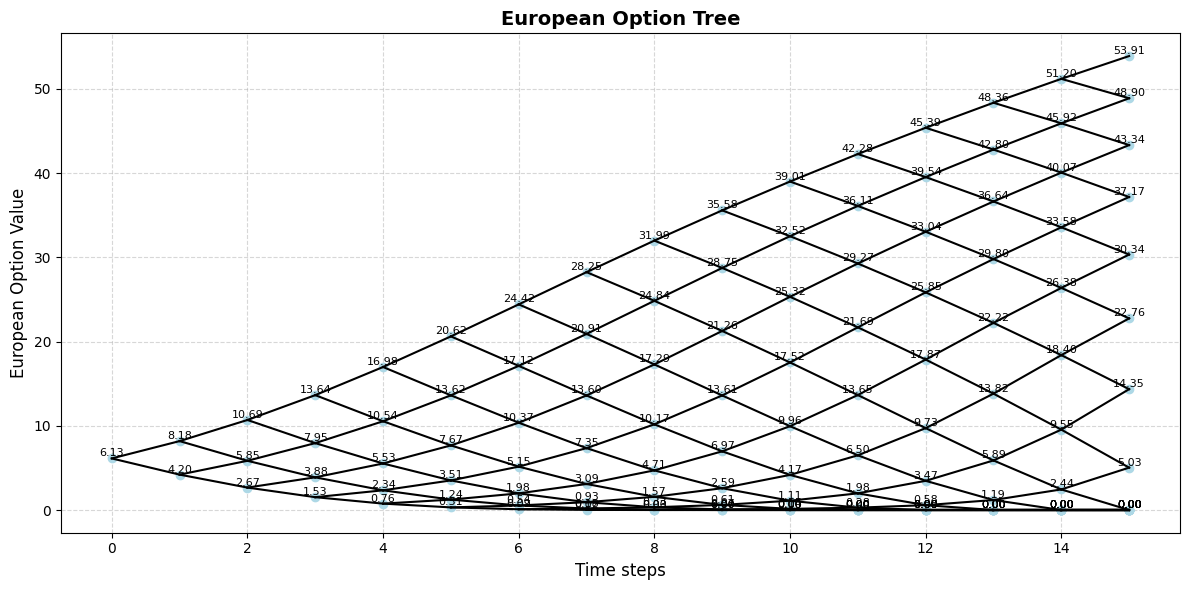

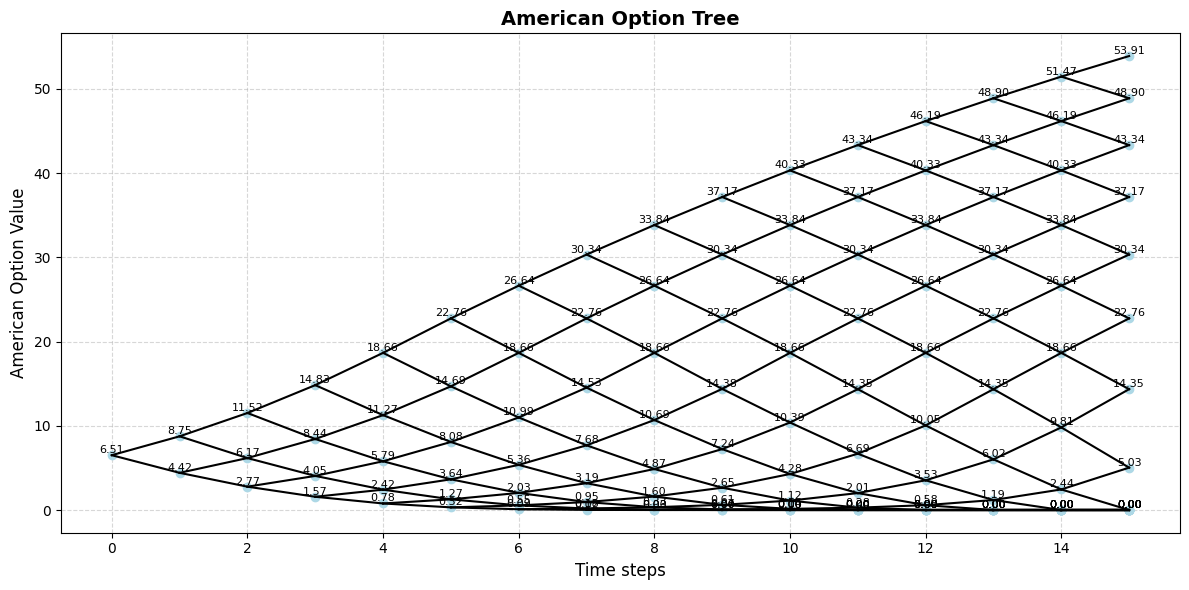

In [9]:
Underlyingtree = binomial_tree(S_0,r,T,steps)
visualize_binomial_tree(Underlyingtree,x_axis="Underlyiny", title = "Underlying Tree")
EuropeanTree = EuropeanOptionTree(S_0, r, sigma, T, steps, K,  call=False)
visualize_binomial_tree(EuropeanTree, "European Option Value", title="European Option Tree")
AmericanTree = AmericanOptionTree(S_0, r, sigma, T, steps, K, call=False)
visualize_binomial_tree(AmericanTree, "American Option Value", title="American Option Tree")

### Comments
Consistently with the Theory the American put option is more expensive due a positive $Early \ Exercise \ Premium$. By turning the boolean *call* from "False" to "True" for both the American and the European tree it is possible to see identical option trees, a result that is consistant with the fact that in absence of dividends, under positive risk free rate, it is never optimal to early exercise an American Call.

### b) **Compute and visualize the $Early$ $Exercise$ $Boundary$ for an American put option. Assuming a sufficiently small time-step, use Monte Carlo simulation to compute the Risk-Neutral probability that an American put option is early exercised and plot the $Optimal$ $Stopping$ $Time$ distribution for an ITM put option.**

We start from computing the early exercise barrier. For each time layer $i$, collect the set of prices where immediate exercise occurs:
$$
\mathcal{E}_i \;=\; \big\{\, S(t,k)\ :\ \big|V(t,k)-payoff(S(t,k))\big|\le \varepsilon \ \ \text{and}\ \ payoff(S(t,k))>0 \,\big\}.
$$

Define the **exercise barrier** $B_i$ as the edge of the exercise region:
- **Call:** exercise when $S\ge B_i$, hence 
  $$
  B_i \;=\; \min\,\mathcal{E}_i.
  $$
- **Put:** exercise when $S\le B_i$, hence 
  $$
  B_i \;=\; \max\,\mathcal{E}_i.
  $$
The raw barrier extracted from the tree will not look smooth, instead it will look like a **"zig-zag"** (due to the binomial nature of the tree) but globally monotonic function. We need to have a barrier as smooth as possible otherwise the optimal stopping time histogram will not look smooth. To get a smooth barrier we use a **weighted cubic spline** (an unweighted cubic spline will interpolate correctly only either the upper or the lower end of the barrier, but as we will see we need reliable estimates on both sides since we are analyising an ITM put). 

In [47]:
def exercise_barrier_raw(S_0: float, 
                     r: float,
                     sigma: float, 
                     T: int, 
                     steps: int,
                     K: float,
                     call=False):
    
    ''' 
    defines the minimum price barrier below (above) which an American put (call) option 
    is early exercised. The output is a dictionary that has steps as key and the barrier 
    as value.  
    OUTPUT: barrier : dict {step: (barrier_price)} 
    '''

    price_tree = binomial_tree(S_0, sigma, T, steps) 
    american_tree = AmericanOptionTree(S_0, r, sigma, T, steps, K, call)

    barrier = {}

    for i in range(steps):
        exercised_prices = [] # initialize list
        for j in range(i + 1):
            S = price_tree[(i, j)]
            V = american_tree[(i, j)]
            payoff = max(S - K, 0) if call==True else max(K - S, 0)

            # Check if the value of the option is equal to the instantaneous payoff
            if abs(V-payoff) <= 1e-8 and payoff > 0:
                exercised_prices.append(S)

        #  If at least one early excercise occurs at i, take the minimum price at which it occured
        if exercised_prices: #check if the list is not empty
            barrier[i] = min(exercised_prices) if call==True else max(exercised_prices)


    return barrier

def exercise_barrier_smooth(S_0: float, 
                     r: float,
                     sigma: float, 
                     T: int, 
                     steps: int,
                     K: float, 
                     time_slope = 0.95,
                     weight = 3,
                     smoother = 150,
                     call=False):
    
    ''' 
    computes the barrier and smooths it via a cubic spline. To better 
    capture the shape different weights are assumed in the distribution:

    - weight: sets the weight to be assigned to all the observation above "time_slope"
    - time_slope: sets a time above which the weight parameter enters in action
    - smoother: in the smoothing parameter in the cubic spline

    OUTPUT: smooth_barrier : dict {step: (barrier_price)} 
    '''
    
    barrier = exercise_barrier_raw(S_0, r, sigma, T, steps, K,call=False)
    steps_list = [i for i in sorted(barrier.keys())]
    prices = [barrier[i] for i in steps_list]

    dt = T / steps
    times = np.array([i * dt for i in steps_list])
    w = np.ones_like(times)
    w[times > T*time_slope] = weight

    spl = UnivariateSpline(times, prices,w=w, s=smoother)  
    prices_new = spl(times)
    smooth_barrier = dict(zip(steps_list, prices_new))

    return smooth_barrier


### Implementation
Via visual analysis we can set the $\texttt{time\_slope}$, $\texttt{weight}$, $\texttt{smoother}$ parameters to better fit the barrier. 


In [48]:
# set up the parameters
S_0 = 100
K = 120 # ITM put
T = 1
r = 0.04
sigma = 0.2
steps = 100

{3: 95.03276096378696, 4: 95.01545124171598, 5: 95.00255670241837, 6: 94.99402500266073, 7: 94.98980379920957, 8: 94.98984074883138, 9: 94.99408350829269, 10: 95.00247973435992, 11: 95.01497708379966, 12: 95.03152321337839, 13: 95.05206577986262, 14: 95.07655244001886, 15: 95.1049308506136, 16: 95.13714866841339, 17: 95.17315355018472, 18: 95.21289315269406, 19: 95.25631513270794, 20: 95.30336714699285, 21: 95.35399685231533, 22: 95.40815190544188, 23: 95.46577996313898, 24: 95.52682868217316, 25: 95.59124571931092, 26: 95.65897873131877, 27: 95.7299753749632, 28: 95.80418330701075, 29: 95.8815501842279, 30: 95.96202366338117, 31: 96.04555140123706, 32: 96.13208105456205, 33: 96.22156028012269, 34: 96.31393673468548, 35: 96.4091580750169, 36: 96.50717195788347, 37: 96.60792604005172, 38: 96.71136797828812, 39: 96.81744542935921, 40: 96.92610605003148, 41: 97.03729749707142, 42: 97.15096742724559, 43: 97.26706349732045, 44: 97.3855333640625, 45: 97.50632468423825, 46: 97.62938511461425,

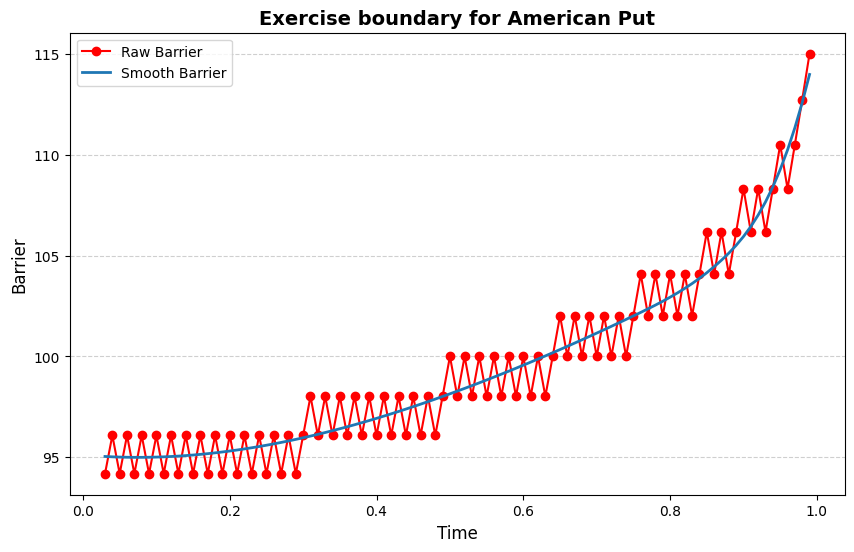

In [50]:
barrier = exercise_barrier_raw(S_0, r, sigma, T, steps, K,call=False)
new_barrier = exercise_barrier_smooth(S_0, r, sigma, T, steps, K, 0.95, 3, 180)
steps_list = [i for i in sorted(barrier.keys())]
raw_barrier = [barrier[i] for i in steps_list]
smooth_barrier = [new_barrier[i] for i in steps_list]
print(new_barrier)

dt = T / steps
times = np.array([i * dt for i in steps_list])
plt.figure(figsize=(10,6))
plt.xlabel("Time", fontsize=12)
plt.ylabel("Barrier", fontsize=12)
plt.title("Exercise boundary for American Put", fontsize=14, weight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.plot(times, raw_barrier, 'o', linestyle='-', color = 'r', label='Raw Barrier')
plt.plot(times, smooth_barrier, '-', lw=2, label='Smooth Barrier')
plt.legend()
plt.show()

### Comments
Consistently with the Theory the Early Exercise Barrier of an American put is **monotonically increasing** converging to the strike at maturity, this is due to the fact that the **Early Exercise Premium** erodes as we approach the maturity and this pushes the Early Exercise Barrier above.

As the time step goes to zero, Cox-Ross-Rubenstein underlying dynamic converges to a $Geometric \ Brownian \ Motion$. On a grid $t_i = i\,\Delta t$ with $\Delta t = T/\text{steps}$, the risk–neutral GBM evolves as
$$
dS_t = S_tr\,dt + \sigma\,dW_t,
\qquad
S_{i} = S_{i-1}\,\exp\!\Big((r-\tfrac12\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z_i\Big),
$$
where $Z_i \sim \mathcal N(0,1)$ i.i.d.



We can then simulate the Underlying trajectories under the Q-measure and count the trajectories that lead to an early exercise using the $\texttt{exercise\_barrier\_smooth}$ function defined above and approximate numerically the RNP, and its Confidence Interval:

$$
I^{(m)} \;=\; \mathbf{1}\Big\{\exists\, i\in\{1,\dots,\text{steps}-1\}:
\begin{cases}
S^{(m)}_i \ge B_i, & \text{call},\\
S^{(m)}_i \le B_i, & \text{put},
\end{cases}
\Big\},
$$

$$
\widehat{\mathrm{RNP}} \;=\; \frac{1}{n_{\text{sim}}}\sum_{m=1}^{n_{\text{sim}}} I^{(m)}.
$$

A $95\%$ Wald confidence interval is
$$
\widehat{\mathrm{RNP}} \ \pm\ z_{0.975}\,
\sqrt{\frac{\widehat{\mathrm{RNP}}\big(1-\widehat{\mathrm{RNP}}\big)}{n_{\text{sim}}}},
\qquad z_{0.975}\approx 1.96.
$$


In [13]:
def risk_neutral_exercise_probability_MC(S_0: float,
                                         K: float,
                                         r: float,
                                         sigma: float,
                                         T: int,
                                         steps: int,
                                         n_sim: int,
                                         time_slope = 0.95,
                                         weight = 3,
                                         smoother = 150,
                                         call = False):
    
    ''' 
    Using Monte Carlo methods simulates the underlying using a GBM and estimates the 
    RNP of the option being early exercised and its 5% Confidence Interval.

    OUTPUT: RNP, [RNP-CI_radius, RNP+CI_radius]
    '''

    dt = T / steps
    barrier = exercise_barrier_smooth(S_0, r, sigma, T, steps, K, time_slope, weight, smoother, call=call)

    count_exercised = 0

    for _ in range(n_sim):
        S = S_0 
        exercised = False
        for i in range(1, steps):
            Z = np.random.normal()
            S *= np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*Z)
        # only check if we computed a barrier at time i
            if i in barrier:
                hit = (call and S >= barrier[i]) or (not call and S <= barrier[i])
                if hit:
                    exercised = True
                    break
        if exercised == True:
            count_exercised += 1

    RNP = count_exercised / n_sim
    
    SE = np.sqrt(RNP*(1-RNP)/n_sim) # computes the standard error of the estimator
    z = norm.ppf(0.975)
    CI = [RNP-z*SE,RNP+z*SE]

    return RNP , CI


### Implementation

In [14]:
# set up the parameters
S_0 = 100
K = 120 # ITM put
T = 1
steps = 15
r = 0.04
sigma = 0.2
steps = 500

In [15]:
risk_neutral_exercise_probability_MC(S_0, K, r, sigma, T, steps, 100000)

(0.88277, [0.8807761556298784, 0.8847638443701217])

Using the Geomtric Brownian motion we can also compute the **optimal stopping time distribution**. In particular, we first create a function that collects for each trajectory the $first \ hitting \ time$ of the barrier, and a second function that plots them in a histogram with densities. 

In [16]:
def optimal_stopping_time_MC(S_0: float,
                             K: float,
                             r: float,
                             sigma: float,
                             T: float,
                             steps: int,
                             n_sim: int,
                             time_slope=0.95,
                             weight=3,
                             smoother=150,
                             call=False):
    
    ''' 
    Using Montecarlo simulation creates a list of the times the options is early exercised

    OUTPUT: list(stopping_times), times it can be exercised
    '''

    barrier= exercise_barrier_smooth(S_0, r, sigma, T, steps, K, time_slope, weight, smoother,call=call)

    dt = T / steps
    steps_list = np.array(sorted(barrier.keys()))
    S_star = np.array([barrier[t] for t in steps_list])
    times = np.array([t * dt for t in steps_list])

    stopping_times = []
    for _ in range(n_sim):
         S = S_0
         last_step = 0
         exercised = False
         for idx, t_idx in enumerate(steps_list):
                # simulate from last_step up to t_idx
                Z = np.random.normal()
                S *= np.exp((r - 0.5*sigma**2)*(t_idx - last_step)*dt + sigma*np.sqrt((t_idx - last_step)*dt)*Z)
                last_step = t_idx

                # check exercise condition
                if (call  and S >= S_star[idx]) or (not call and S <= S_star[idx]):
                    stopping_times.append(times[idx])
                    exercised = True
                    break
    
    return stopping_times, times

def visualize_stopping_times_distribution(stopping_times: list,
                                          times: np.array):
    
    """
    Plot a histogram of the stopping times.
    """
    
    if not stopping_times:
        print("No early‐exercise occurred in any path.")
        return

    plt.figure(figsize=(10, 6))
    plt.hist(stopping_times, bins=times, edgecolor='black', alpha=0.85, density=True)
    plt.title("Optimal Stopping Time Distribution", fontsize=14, weight='bold')
    plt.xlabel("Time to Early Exercise (years)", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


### Implementation

In [17]:
# set up the parameters
S_0 = 100
K = 115 # ITM put
T = 1
steps = 15
r = 0.04
sigma = 0.2
steps = 500

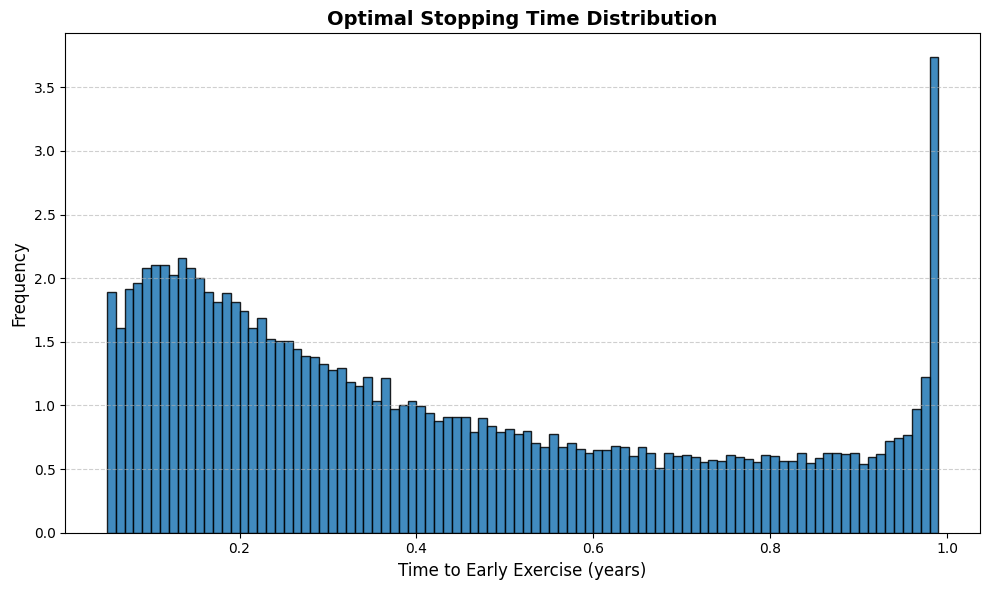

In [18]:
steps = 100
stopping_times, times = optimal_stopping_time_MC(S_0, K, r, sigma, T, steps, n_sim=80000)
visualize_stopping_times_distribution(stopping_times, times)

### Comments
Predictibly the stopping time distribution is $bimodal$ , and this is strictly connected with the fact that the option is ITM. Indeed, the underlying starts ITM and a further decrease can trigger an early exercise even in the first time steps; if the barrier instead is not hitted in the first time steps it must have meant that the underlying increased going further away from the barrier and this is reflected in a decrease in the densities of the stopping time distribution. As we approach the maturity the barrier starts to increase faster and this pushes the barrier closer to the underlying price triggering early exercises which motivates why the stopping time density increases as we approach maturity. The shape of the stopping time distribution motivates also why we needed previously to capture correctly the early exercise barrier on both ends, using the weighted cubic spline. Playing with parameters it is easy to see (and understand) that an ATM or OTM option will instead tend to have a $unimodal$ distribution.

### c) **Compute and visualize the Cox-Ross-Rubinstein $ Trinomial \ Tree $ (without dividends) of the underlying, and the American Put Option. Compare the priceing engine of the American Option using binomial tree with the one using trinomial tree as you increase the number of steps. For which pricing engine  is the convergence faster? Find an explanation of the result.**

I opted for an optimized code using $\texttt{njit}$ from $\texttt{numba}$, as this will be fundamental to make computationally feasible the next point.

Let's start by creating a function that creates the trinomial tree of the underlying and allows to visualize it. With respect to the binomial tree the catch is that we are using numba, where we cannot use dictionaries, that is the reason why we shifted the representation of the trinomial tree to a 2d numpy array. In particular the CRR trinomial tree has the following characteristics:

$$
u \;=\; e^{\sigma\sqrt{2\,\Delta t}},\qquad d \;=\; \frac{1}{u},\qquad m \;=\; 1.
$$


In [52]:
@njit(cache=True)
def trinomial_tree(S_0: float,
                   sigma: float,
                   T: float,
                   steps: int):

    """
    Builds a trinomial tree in a 2D array `tree` where:
      - tree[t, node_idx = k+offset] = price at time-step t with k net up-moves (k ∈ [-t, +t])
      - offset = steps, so columns run 0 .. 2*steps
    OUTPUT: tree: 2d_array[time,node_idx] = price
    """

    dt = T / steps
    u = np.exp(sigma * np.sqrt(2*dt))
    d = 1.0 / u

    # pre-allocate (steps+1) × (2*steps+1)
    ncols = 2 * steps + 1
    tree = np.zeros((steps + 1, ncols), dtype=np.float64)
    offset = steps

    # root
    tree[0, offset] = S_0

    # fill levels
    for t in range(1, steps + 1):
        for k in range(-t, t + 1):
            idx = k + offset
            if k == t:
                # all ups from (t-1, k-1)
                parent = tree[t-1, idx-1]
                tree[t, idx] = parent * u
            elif k == -t:
                # all downs from (t-1, k+1)
                parent = tree[t-1, idx+1]
                tree[t, idx] = parent * d
            else:
                # middle move from (t-1, k)
                parent = tree[t-1, idx]
                tree[t, idx] = parent
    return tree

def visualize_trinomial_tree_array(tree_arr: np.array,
                                    x_axis="Asset Price",
                                    title="Trinomial Tree"):

    '''
    plots the trinomial tree using real distances
    '''
    
    fig, ax = plt.subplots(figsize=(12, 6))
    pos = {}
    labels = {}

    steps = tree_arr.shape[0] - 1
    offset = steps

    # build positions & labels
    for t in range(steps + 1):
        for k in range(-t, t + 1):
            price = tree_arr[t, k + offset]
            x, y = t, price
            pos[(t, k)] = (x, y)
            labels[(t, k)] = f"{price:.2f}"

    # draw nodes
    for (t, k), (x, y) in pos.items():
        ax.plot(x, y, 'o', color='lightblue')
        ax.text(x, y, labels[(t, k)], ha='center', va='bottom', fontsize=8)

    # draw branches
    for (t, k), (x, y) in pos.items():
        if t < steps:
            for dk in (-1, 0, 1):
                child = (t + 1, k + dk)
                if child in pos:
                    x2, y2 = pos[child]
                    ax.plot([x, x2], [y, y2], 'k-')

    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("Time step", fontsize=12)
    ax.set_ylabel(x_axis, fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

We need to create a function that prices an American Option. The **backward recursion** is fundamentally identical with the one used on the binomial tree, with the tweak that instead of using dictionary keys to retrieve the following nodes we need to use indexes of the numpy array. In detail the RNPs are:

$$ q_u = \Big(\frac{(\sqrt{e^{r\Delta t}}) - \sqrt{d}}{\sqrt{u} - {\sqrt{d}}}\Big)^2 \qquad q_d=\Big(\frac{\sqrt{u} - (\sqrt{e^{r\Delta t}}) }{\sqrt{u} - {\sqrt{d}}}\Big)^2 \qquad q_m = 1-q_u-q_d $$

In [53]:
@njit
def AmericanOptionTrinomialTree(S_0: float,
                                r: float,
                                sigma: float,
                                T: int,
                                steps: int, 
                                K: float,
                                call=False):
    
    '''
    defines the tree of the American Option
    OUTPUT: AmericanTree: 2d array[time,node_idx] = option value
    '''
    
    dt = T/steps
    u = np.exp(sigma * np.sqrt(2*dt))
    d = 1/u
    a = np.exp(r * dt)
    q_u = ((np.sqrt(a) - 1/np.sqrt(u)) / (np.sqrt(u) - 1/np.sqrt(u)))**2
    q_d = ((np.sqrt(u) - np.sqrt(a))  / (np.sqrt(u) - 1/np.sqrt(u)))**2
    q_mid = 1 - q_u - q_d

    tree = trinomial_tree(S_0,sigma,T,steps)
    AmericanTree = np.zeros_like(tree)
    offset = steps
   
    # Terminal payoffs

    for j in range(-steps, steps + 1):
        idx = j + offset
        ST = tree[steps, idx]
        AmericanTree[steps, idx] = max(ST - K, 0) if call==True else max(K - ST, 0)

    # Backward induction with early exercise
    for t in range(steps - 1, -1, -1):
        for j in range(-t, t + 1):
            idx = j + offset
            expected = q_u * AmericanTree[t + 1, idx + 1] + q_mid * AmericanTree[t+1, idx]+ q_d * AmericanTree[t + 1, idx-1]
            continuation = expected / a
            intrinsic = max(tree[t, idx] - K, 0) if call else max(K - tree[t, idx], 0)
            AmericanTree[t, idx] = max(continuation, intrinsic) # check for early exercise

    return AmericanTree



### Implementation
we plot the Underlying tree and the ATM American put option tree. 

In [54]:
# set up the parameters
S_0 = 100
K = 100
T = 1
steps = 15
r = 0.04
sigma = 0.2

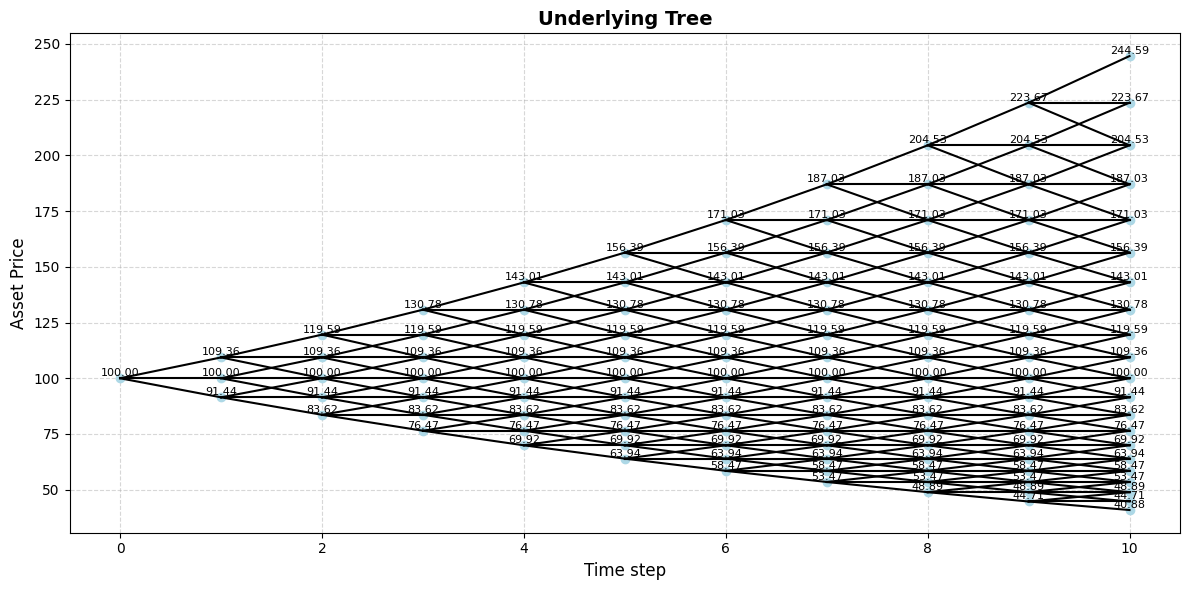

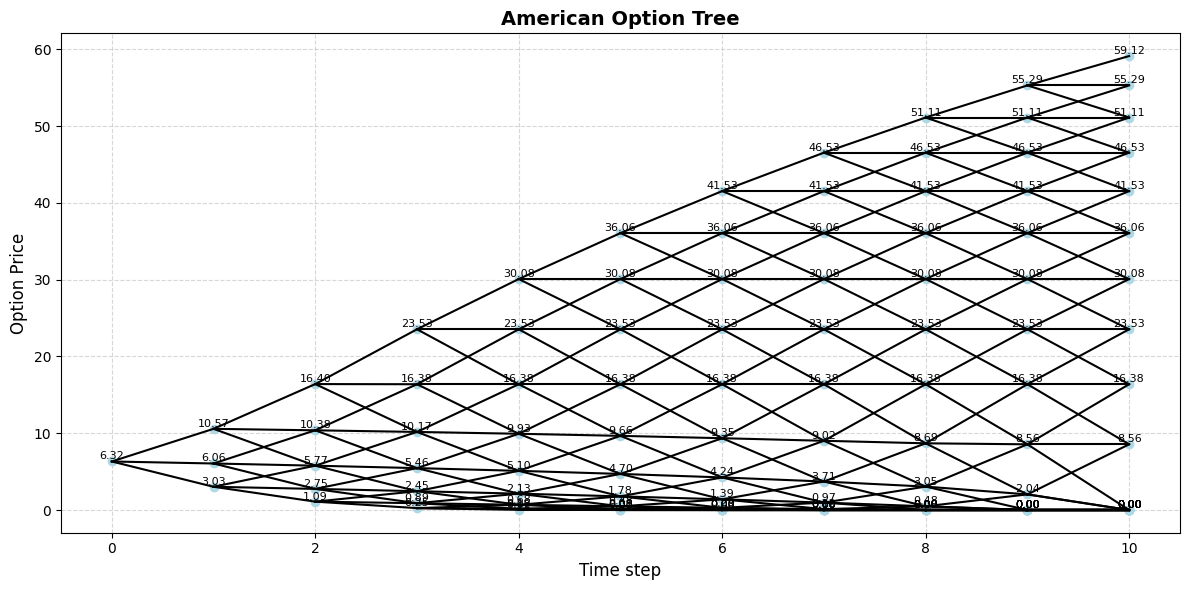

In [55]:
steps = 10
UnderlyingTree=trinomial_tree(S_0, sigma, T, steps)
visualize_trinomial_tree_array(UnderlyingTree, x_axis="Asset Price", title="Underlying Tree")
AmericanTree = AmericanOptionTrinomialTree(S_0, r, sigma, T, steps, K, call=False)
visualize_trinomial_tree_array(AmericanTree, x_axis="Option Price", title="American Option Tree")

We are now required to compare the pricing using the binomial tree with the pricing using the trinomial tree. We create a function that plots the price of the option at time 0 (this can be retrieved as the root element of each option tree) as we change the $\texttt{steps}$ argument in the pricing functions. To assess which method converges faster we also draw an horizontal line at a given benchmark, which is obtained using one of the two methods with a relatively high $\texttt{steps}$ argument, thus working as a proxy of the continuous time price.

In [64]:
def Trinomial_vs_Binomial(S_0: float,
                           r: float,
                           sigma: float,
                           T: float,
                           steps_list: list,
                           K: float,
                           benchmark: float,
                           call=False):

    ''' 
    plots the prices obtained via backward recursion over the binomial
    tree with the one obtained over a trinomial tree with the different steps numbers 
    included in steps_list. It also requires a benchmark to assess how fast the two methods converge. 
    '''

    dim = len(steps_list)
    prices_trinomial = []
    prices_binomial = []

    for steps in steps_list:
        trinomial_tree = AmericanOptionTrinomialTree(S_0, r, sigma, T, steps, K, call=False)
        prices_trinomial.append(trinomial_tree[0,steps])
        binomial_tree = AmericanOptionTree(S_0, r, sigma, T, steps, K, call=False)
        prices_binomial.append(binomial_tree[(0,0)])

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(steps_list, prices_trinomial, color='g', label='Trinomial tree Prices')
    plt.plot(steps_list, prices_binomial, color='r', label='Binomial tree Prices')
    plt.axhline(y=benchmark, linewidth=1, color='b',label='Benchmark')
    plt.xlabel('Steps', fontsize=12)
    plt.ylabel('American Option Price', fontsize=12)
    plt.title('Binomial vs Trinomial Tree pricing', fontsize=14, weight='bold')
    plt.legend()
    plt.tight_layout()
    plt.show()

### Implementation
We implement now the above function. The parameters have been chosen to make particularly evident the result.

In [58]:
# parameters to better assess which method converges faster
S_0, K = 100.0, 100.0
r      = 0.01 #low r         
sigma  = 0.5  #high vol        
T      = 2.0  #high maturity 
benchmark = AmericanOptionTrinomialTree(S_0, r, sigma, T, 1000, K, call=False)[0,1000] # sets the benchmark 

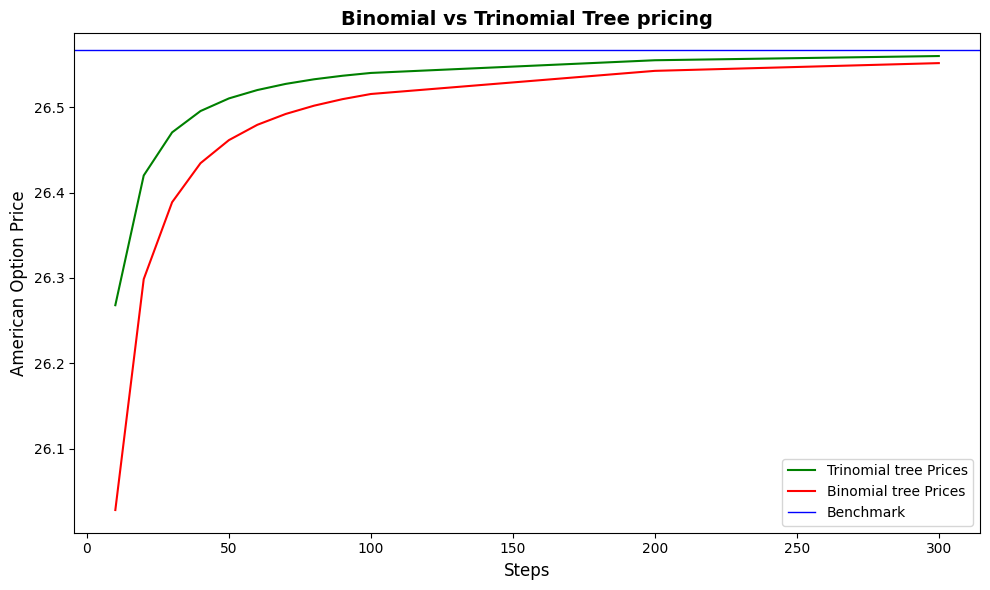

In [65]:
steps_list = [10, 20, 30, 40, 50, 60, 70 ,80 ,90, 100, 200, 300]
Trinomial_vs_Binomial(S_0, r, sigma, T, steps_list, K, benchmark, call=False)

### Comments 
We observe that the trinomial tree convergence is clearly faster, to discover why we observe that as we increase the number of steps the trinomial dynamics for the underlying converge faster then the binomial dynamics to the continuous time, yielding also a faster convergence to the continuous time price for the derivative. Let's create an **animation** where we can see both both trees increasing their number of steps and the pmf of their respective underlying at matuirty vs Black Scholes log-normal density

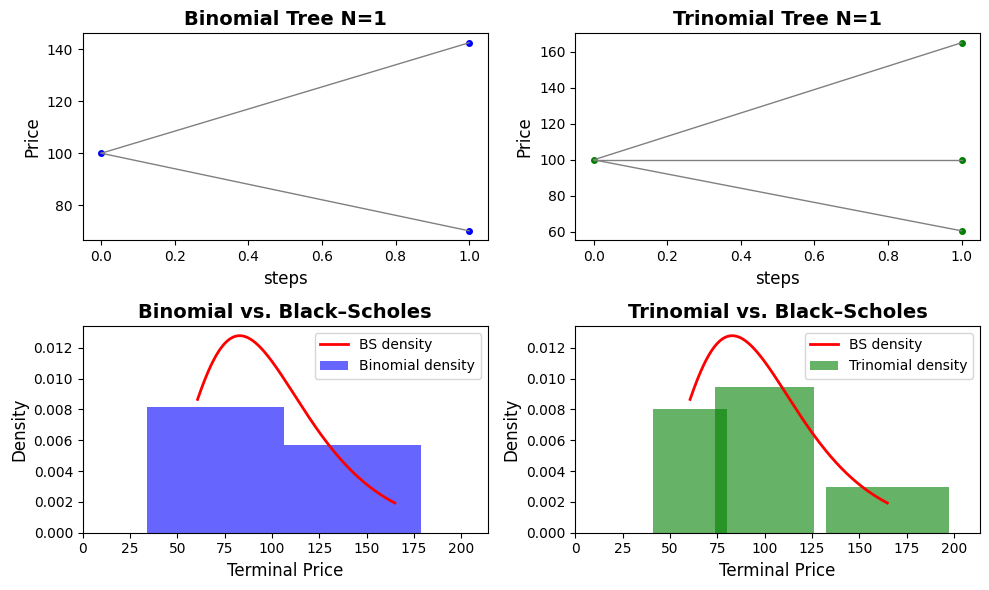

In [66]:
# New plotting functions that accept an Axes object
def plot_binomial_tree(ax, tree: dict, title="Binomial Tree"):
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("steps", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    pos = {}
    # scatter nodes and store positions
    for (t, k), price in tree.items():
        ax.plot(t, price, 'o', color='blue', markersize=4)
        pos[(t, k)] = (t, price)
    # draw branches
    max_t = max(t for (t, k) in tree.keys())
    for (t, k), (x, y) in pos.items():
        if t < max_t:
            for dk in (0, 1):
                child = (t + 1, k + dk)
                if child in pos:
                    x2, y2 = pos[child]
                    ax.plot([x, x2], [y, y2], '-', color='gray', linewidth=1)

def plot_trinomial_tree(ax, tree_arr: np.ndarray, title="Trinomial Tree"):
    ax.set_title(title, fontsize=14, weight='bold')
    ax.set_xlabel("steps", fontsize=12)
    ax.set_ylabel("Price", fontsize=12)
    steps = tree_arr.shape[0] - 1
    offset = steps
    pos = {}
    # scatter nodes and store positions
    for t in range(steps + 1):
        for j in range(-t, t + 1):
            price = tree_arr[t, j + offset]
            ax.plot(t, price, 'o', color='green', markersize=4)
            pos[(t, j)] = (t, price)
    # draw branches
    for (t, j), (x, y) in pos.items():
        if t < steps:
            for dj in (-1, 0, 1):
                child = (t + 1, j + dj)
                if child in pos:
                    x2, y2 = pos[child]
                    ax.plot([x, x2], [y, y2], '-', color='gray', linewidth=1)


# Animation setup
S0, r, sigma, T = 100, 0, 0.25, 2.0
frames = list(range(1,51))

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
(ax_bin, ax_tri), (ax_hist, ax_hist2) = axes


from math import comb

def update(N):
    # clear all axes
    for ax in axes.flatten():
        ax.clear()

    # obtain the trees
    btree = binomial_tree(S0, sigma, T, N)
    tarry = trinomial_tree(S0, sigma, T, N)
    plot_binomial_tree(ax_bin, btree, title=f"Binomial Tree N={N}")
    plot_trinomial_tree(ax_tri, tarry, title=f"Trinomial Tree N={N}")


    dt = T / N

    # binomial tree pmf estimate
    u_bin = np.exp(sigma * np.sqrt(dt))
    d_bin = 1 / u_bin
    a_bin = np.exp(r * dt)
    q_bin = (a_bin - d_bin) / (u_bin - d_bin)
    k = np.arange(N+1)
    bin_prices = S0 * (u_bin**k) * (d_bin**(N - k))
    bin_pmf    = np.array([comb(N, ki) * q_bin**ki * (1-q_bin)**(N-ki) for ki in k])
    # convert it to density
    widths_bin = np.empty_like(bin_prices)
    widths_bin[1:-1] = (bin_prices[2:] - bin_prices[:-2]) / 2
    widths_bin[0]    = bin_prices[1] - bin_prices[0]
    widths_bin[-1]   = bin_prices[-1] - bin_prices[-2]
    bin_density = bin_pmf / widths_bin

    # trinomial density estimate
    u_tri = np.exp(sigma * np.sqrt(2*dt))
    d_tri = 1 / u_tri
    a_tri = np.exp(r * dt)
    sqa, squ, sqd = np.sqrt(a_tri), np.sqrt(u_tri), 1/np.sqrt(u_tri)
    q_u = ((sqa - sqd) / (squ - sqd))**2
    q_d = ((squ - sqa) / (squ - sqd))**2
    q_m = 1 - q_u - q_d

    one_step = np.array([q_d, q_m, q_u])
    tri_pmf = one_step.copy()
    for _ in range(1, N):
        tri_pmf = np.convolve(tri_pmf, one_step)

    j = np.arange(-N, N+1)
    tri_prices = S0 * (u_tri**j)
    # convert it to density
    widths_tri = np.empty_like(tri_prices)
    widths_tri[1:-1] = (tri_prices[2:] - tri_prices[:-2]) / 2
    widths_tri[0]    = tri_prices[1] - tri_prices[0]
    widths_tri[-1]   = tri_prices[-1] - tri_prices[-2]
    tri_density = tri_pmf / widths_tri

    # Black Scholes continuous log‑normal
    mu, var = (r - 0.5*sigma**2)*T, sigma**2*T
    x_full = np.linspace(
        min(bin_prices.min(), tri_prices.min()),
        max(bin_prices.max(), tri_prices.max()), 300
    )
    pdf_full = stats.lognorm(s=np.sqrt(var), scale=S0*np.exp(mu)).pdf(x_full)

    # compute a right‐cutoff at the 99th percentile. 
    # This makes sure that as we increase the steps, the histogram do not get squished on the y-axis as the right-tail gets longer.
    right_cut = stats.lognorm.ppf(0.99, s=np.sqrt(var), scale=S0*np.exp(mu))

    # bottom‑left: binomial tree histogram + BS density
    ax_hist.bar(bin_prices, bin_density, width=widths_bin, alpha=0.6, color='blue',
                label="Binomial density")
    ax_hist.plot(x_full, pdf_full, 'r-', lw=2, label="BS density")
    ax_hist.set_title("Binomial vs. Black–Scholes", fontsize=14, weight='bold')
    ax_hist.set_xlabel("Terminal Price", fontsize=12)
    ax_hist.set_ylabel("Density", fontsize=12)
    ax_hist.legend()
    ax_hist.set_xlim(left=0, right=right_cut)

    # bottom‑right: trinomial tree histogram + BS density
    ax_hist2.bar(tri_prices, tri_density, width=widths_tri, alpha=0.6, color='green',
                 label="Trinomial density")
    ax_hist2.plot(x_full, pdf_full, 'r-', lw=2, label="BS density")
    ax_hist2.set_title("Trinomial vs. Black–Scholes", fontsize=14, weight = 'bold')
    ax_hist2.set_xlabel("Terminal Price",fontsize=12)
    ax_hist2.set_ylabel("Density",fontsize=12)
    ax_hist2.legend()
    ax_hist2.set_xlim(left=0, right=right_cut)

    plt.tight_layout()

ani = FuncAnimation(fig, update, frames=frames, interval=1000, repeat=True)


### Implementation
We display the animation (could take minutes)

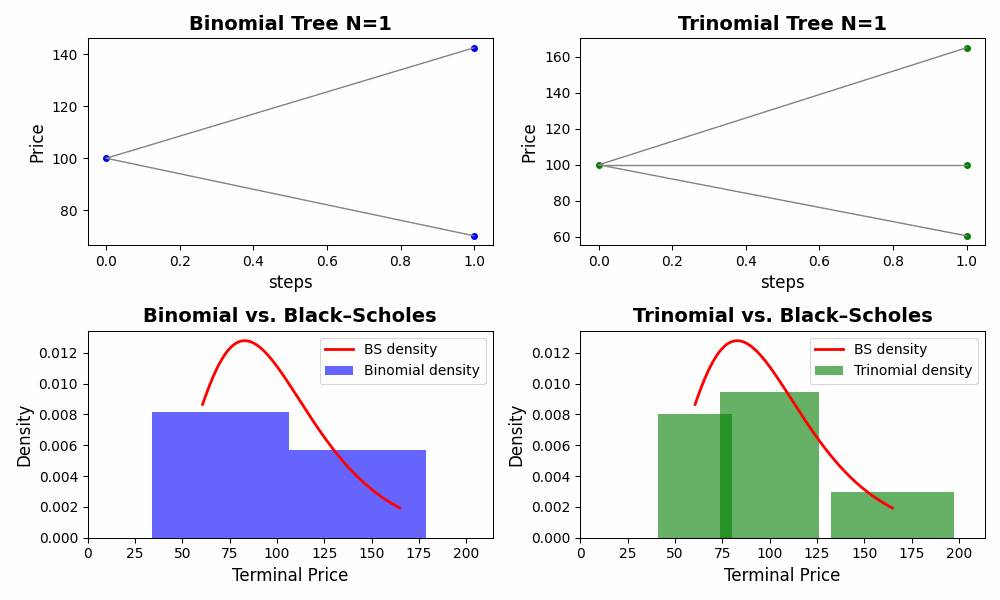

<Figure size 640x480 with 0 Axes>

In [67]:
# Save the animation as a GIF 
ani.save('tree_animation.gif', writer='pillow', fps=5)

# Display it inline
Image('tree_animation.gif')

### Comments
We can see that as the steps grow the pmf of the underlying under the trinomial tree at maturity converges faster to the pdf of the $Black-Scholes$ lognormal distribution with respect to the binomial tree. This shows that the faster convergence in American option pricing of the trinomial tree is just a consequence of the trinomial tree underlying converging faster to the continuous time dynamics. The reason that the CRR trinomial tree converges faster is that it matches exactly the first two moment of the 1-step underlying price, while the CRR binomial tree matches only the first moment:

**Actual moments of BS lognormal underlying**: 

$$ \mathbb E[S_{t+\Delta t}|\mathcal{F}_t] = S_te^{r\Delta t} \qquad \mathbb E[S_{t+\Delta t}^2|\mathcal{F}_t] = S_t^2e^{2r\Delta t + \sigma^2\Delta t}$$

**Moments under CRR binomial tree**: \
Exact match of the first moment using the only degree of freedom $q_{u}$:
$$ \mathbb E[S_{t+\Delta t}|\mathcal{F}_t] = S_te^{r\Delta t} $$
Square error bias in the second moment:
$$ \mathbb E[S_{t+\Delta t}^2|\mathcal{F}_t] = S_t^2e^{2r\Delta t + \sigma^2\Delta t} + O(\Delta t^2) $$

**Moments under CRR trinomial tree**: \
Exact match of the first moment using the first degree of freedom ${q_{u}}$:
$$ \mathbb E[S_{t+\Delta t}|\mathcal{F}_t] = S_te^{r\Delta t} $$
Exact match of the second moment using the second degree of freedom ${q_d}$:
$$ \mathbb E[S_{t+\Delta t}^2|\mathcal{F}_t] = S_t^2e^{2r\Delta t + \sigma^2\Delta t} $$

### d) **Price an American lookback put with payoff: $ max_{\{0< s < t \}}S(s) - S(t) $ using the $ Forward \ Shooting \ Grid $ algorithm built over the trinomial tree. Show how that the $Richardson \ Extrapolation$ can be used to achieve higher computational efficiency.**

We start on by defining the pricer of the the American lookback put via the FSG. Here there is a small description of the **FSG algorithm**:

**Forward Shooting Grid (FSG)** 
- Forward phase: build the **reachable state grid** of pairs $(S_t, M_t)$, where $M_t=\max_{0\le s\le t} S_s$.
- Backward phase: at each reachable state, take the maximum between **immediate payoff** and **discounted continuation**. 

**Forward phase (reachability of $(t,k,m)$)**

We maintain a boolean 3D mask $\texttt{reachable[t, k\_idx, m]}$ indicating whether state
$$
S_{t,k} = \texttt{prices}[t, k\!+\!\text{shift}],\qquad
M_{t}   = \texttt{prices}[t, m]
$$
is **attainable** from the root $(t{=}0,k{=}0,M_0{=}S_0)$.

Initialization:
$$
\texttt{reachable}[0, \text{shift}, \text{shift}] = \text{True}
\quad\text{(since } M_0=S_0\text{).}
$$

Propagation (for each child move $\Delta k\in\{+1,0,-1\}$):
- We $Markovianize$ the problem such that we can update the **running maximum** from parent $(t\!-\!1, k-\Delta k, m)$ to child $(t,k,m')$ with
$$
m' \;=\; \max\{m,\; k+\text{shift}\},
$$
i.e., the **index** of the running maximum updates when the price makes a new high.  
This forward sweep marks all **feasible** combinations of current node and running maximum.

**Backward phase (American optimality)**

We store values in a real array $V[t,k,m]$ only on reachable states.

- **Terminal payoff** ($t=N$): floating–strike lookback **put**
$$
V[N,k,m] \;=\; M_{\!N} - S_N.
$$

- **One–step recursion** ($t=N-1,\dots,0$): for each reachable $(t,k,m)$,
  - **immediate payoff**:
  $$
  \text{payoff} \;=\; M_t - S_t,
  $$
  - **continuation value** (PV risk–neutral expectation over the three children, with the **updated** $m'$ at the child):
  $$
  \text{CV} \;=\; e^{-r \Delta t} \Big [ p_u\,V[t{+}1,k{+}1,m_u]
                  + p_m\,V[t{+}1,k,m_m]
                  + p_d\,V[t{+}1,k{-}1,m_d] \Big ],
  $$
  where $m_u=\max\{m,k{+}1+\text{shift}\}$, etc.
  - **American** value:
  $$
  V[t,k,m] \;=\; \max\!\left(\text{payoff},\ \text{cont}\right).
  $$

The option price is the root value
$$
V[0,0,M_0] \;=\; V\big[0,\ \text{shift},\ \text{shift}\big].
$$



In [ ]:
@njit(cache=True)
def price_lookback_american_FSG(S0: float,
                                r: float,
                                T: float,
                                sigma: float,
                                steps: int):
    
    '''
    Prices a spot-starting American-style lookback option using the Forward Shooting Grid (FSG) method with a trinomial tree. 
    The Forward Shooting Grid algorithm can be splitted in two parts:

        - Forward Phase: Constructs a reachable state grid that tracks all combinations of 
          current price levels and historical maximum prices (Mmax) throughout the trinomial tree.

        - Backward Phase: Applies backward recursion to compute the option value at each node, 
          considering both continuation values and immediate payoff for each possible combination of Mmax and following update of Mmax.

    OUTPUT: V[0, S0, S0] = option value: float
    '''

    dt = T / steps
    u = np.exp(sigma * np.sqrt(2*dt))
    d = 1 / u
    a = np.exp(r * dt)
    p_u = ((np.sqrt(a) - 1/np.sqrt(u)) / (np.sqrt(u) - 1/np.sqrt(u)))**2
    p_d = ((np.sqrt(u) - np.sqrt(a))  / (np.sqrt(u) - 1/np.sqrt(u)))**2
    p_m = 1 - p_u - p_d
    
    N = steps
    shift = N

    # Build the trinomial tree
    prices=trinomial_tree(S0, sigma, T, N)

    # Forward Phase : reachable Mmax for each (t, k)
    # Use boolean mask to mark reachable (t,k,m)
    reachable = np.zeros((N + 1, 2 * N + 1, 2 * N + 1), dtype=np.bool_)
    # At root
    reachable[0, shift, shift] = True  # (t=0, k=0, m=0)

    for t in range(1, N + 1):
        for k in range(-t, t + 1):
            k_idx = shift + k
            for dk, prob in ((1, p_u), (0, p_m), (-1, p_d)):
                parent_k = k - dk
                if - (t-1) <= parent_k <= (t-1):
                    parent_idx = shift + parent_k
                    # Carry over reachable M states
                    for m in range(2 * N + 1):
                        if reachable[t-1, parent_idx, m]:
                            # New M index = max(m, k_idx)
                            new_m = m if m > k_idx else k_idx
                            reachable[t, k_idx, new_m] = True

    # Backward Phase : option value V[t,k,m]
    V = np.zeros_like(reachable, dtype=np.float64)
    # At maturity, payoff M - S or S - M
    for k in range(-N, N + 1):
        k_idx = shift + k
        for m in range(2 * N + 1):
            if reachable[N, k_idx, m]:
                S = prices[N, k_idx]
                Mmax = prices[N, m]
                V[N, k_idx, m] = (Mmax - S) 

    # Backward step
    for t in range(N - 1, -1, -1):
        for k in range(-t, t + 1):
            k_idx = shift + k
            for m in range(2 * N + 1):
                if reachable[t, k_idx, m]:
                    S = prices[t, k_idx]
                    Mmax = prices[t, m]
                    intrinsic = (Mmax - S) 
                    cont = 0.0
                    for dk, prob in ((1, p_u), (0, p_m), (-1, p_d)):
                        nk = k + dk
                        nk_idx = shift + nk
                        if - (t+1) <= nk <= (t+1):
                            new_m = m if m > nk_idx else nk_idx
                            cont += prob * V[t+1, nk_idx, new_m]
                    V[t, k_idx, m] = max(intrinsic, cont / a)
    # Return root value
    return V[0, shift, shift]

It is in this code that you can truly observe how usefull **numba** is. In particular the nested loops in both the forward part and the backward part are executed 10x times faster using numba and this makes the pricing feasible even when having high steps in the tree. An alternative not currently implemented to make the code faster is to cap the dimension of the $auxiliary \ running \ vectors$ in the forward part and use a $selection \ procedure$ in the backward part. 

### Implementation

In [29]:
# set up the parameters
S_0 = 100
T = 1
steps = 1000
r = 0.04
sigma = 0.2

In [30]:
price_lookback_american_FSG(S0, r, T, sigma, steps)

14.972706569200794

We now need to use $Richardson \ Extrapolation$, which allow us to have higher precisious without having to increase the dimension of the tree. Richardson extrapolation is partiuclarly convenient since the FSG argorithm scales in general with $O(N^3)$. The extrapolated price is:

$$V^{ext} = \frac{2^pV_N-V_{N/2}}{2^p-1}$$

where $p$ represent the order of convergence ( error of the pricing method $+o(h^p)$, where $h=1/N$ ). For prudence, considering that we are pricing a Path dependant American Option, we will use $p=2$. We thus create a function where we plot the prices obtaianed directly through the function $\texttt{price\_lookback\_american\_FSG}$ with $N$ steps with the price obtained via extrapolation with $N$ and $N/2$ steps and observe the convergence as we increase $N$. As before to assess the speed of convergence we plot horizontally a benchmark.

In [ ]:
def Richardson_extrap(S0: float, 
                      r: float,
                      sigma: float,
                      T: float,
                      steps_list: list,
                      K: float, 
                      benchmark: float):
    
    ''' 
    plots the prices obtained via backward recursion over the trinomial
    tree with the one obtained using Richardson extrapolation with the different steps numbers 
    included in steps_list. It also requires a benchmark to assess how fast the two methods converge. 
    '''

    dim = len(steps_list)
    prices_FSG = []
    prices_extrap = []

    for steps in steps_list:
        price_1 = price_lookback_american_FSG(S0, r, T, sigma, steps)
        prices_FSG.append(price_1)
        price_2 = price_lookback_american_FSG(S0, r, T, sigma, int(steps/2))
        p = 2
        price_extrapolated = (2**p * price_1 - price_2) / (2**p - 1)
        prices_extrap.append(price_extrapolated)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.plot(steps_list, prices_FSG, color='yellow', label='Trinomial tree Prices')
    plt.plot(steps_list, prices_extrap, color='black', label='Richardson Extraplation')
    plt.axhline(y=benchmark, linewidth=1, color='red',label='Benchmark')
    plt.xlabel('Steps', fontsize = 12)
    plt.ylabel('American Option Price', fontsize = 12)
    plt.title('Extrapolated vs non Extrapolated prices', fontsize=14, weight='bold')
    plt.legend()
    plt.show()

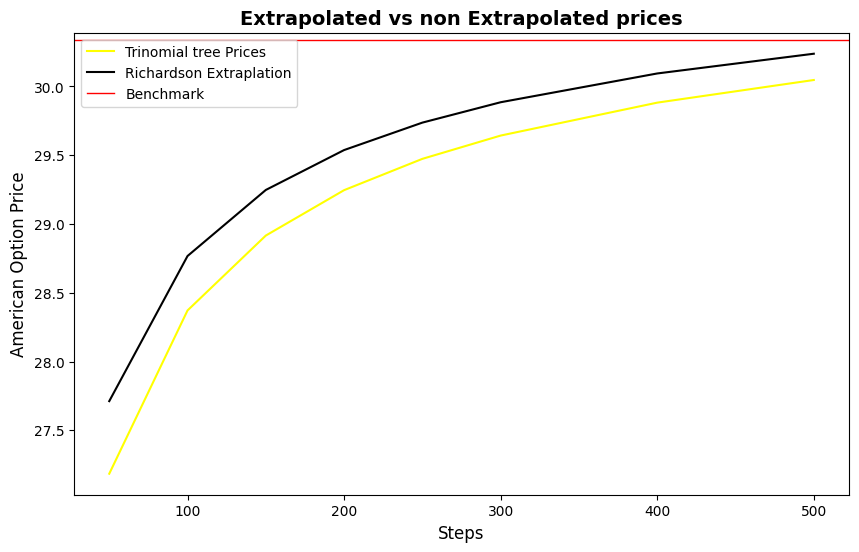

In [72]:
benchmark = price_lookback_american_FSG(S0, r, T, sigma, 800)
steps_list = [50,100,150,200,250,300,400,500]
Richardson_extrap(S_0, r, sigma, T, steps_list, K, benchmark)

### Comments
As we can see  extrapolated prices converge faster. Considering that in our case the cost scales more than linearly, Richardson Extrapolation effectively achieves higher precision with a lower computational cost. A brief reminder: although the convergence is good, the selection of $p = 2$, is kind of arbitrary and a further inspection is required.  

# Exercise 2 (PDE methods)

### a) **Through a change of variables of your choice, trasform the $Black-Scholes$ PDE into the $1D \ Heat \ equation$. Using the $theta \ method$ with asymptotic Dirichlet Boundary conditions for a European call or put, study the stability of $discretization \ scheme$, focusing on $\theta = 1$ (Implicit Euler), $\theta = 1/2$ (Crank-Nicolson), $\theta = 0$ (Explicit Euler).**

We will deploy the following change of variables: 
$$ x = ln\Big (\frac{S}{K} \Big) \qquad \tau = \frac{1}{2}\sigma^2(T-t)$$
We set : $$ \alpha = \frac{1}{2}\Big(1-\frac{2r}{\sigma^2}\Big )$$
We obtain:
$$ V = Ke^{-\alpha x - \alpha^2 \tau}u \Rightarrow u = \frac{V}{Ke^{-\alpha x - \alpha^2 \tau}}$$
and writing the PDE in term of $u$ we have trasformed $Black-Scholes$ PDE into the 1d $Heat \ equation$:
$$\frac{\partial V}{\partial t} + \frac{\partial V}{\partial S}Sr + \frac{\partial^2 V}{\partial S^2}S^2\sigma^2 - rV = 0 \Rightarrow \frac{\partial u}{\partial \tau} = \frac{\partial^2u}{\partial x^2}$$
The terminal condition (the payoff of the European option) in the $(S,t)$ space becomes an initial condition in the $(x,\tau)$ space:
$$ V(S,t=T) = max(\phi(S-K),0) \Rightarrow u(x,\tau=0) = max(\phi(e^x - 1),0)$$
where $\phi = 1$ for calls and $\phi = -1$ for puts. The **Dirichlet Boundary** conditions are first defined in term of $V$ and then are trasformed in term of $u$ and $x_{\min}$ and $x_{\max}$:
1. Left boundary for calls: $V(0,t) = 0$ (asymptotically OTM call)
2. Right boundary for calls: $V(S_{\max},t) = S_{\max} - Ke^{r(T-t)}$ (asymptotically ITM call)

The boundary conditions for the put can be found using the $put-call \ parity$ on the B.C. of the call. Outside of this the theta method has the usual standard implementation for a **diffusion equation**. For interior nodes $j=1,\dots,M-1$ the second difference operator is
$
(\Delta_x u)_j = u_{j+1}-2u_j+u_{j-1}.
$
The $\theta$–scheme for $\frac{\partial u}{\partial \tau} = \frac{\partial^2u}{\partial x^2}$ reads
$$
\big(I-\theta\,\lambda\,L\big)u^{n} = \big(I+(1-\theta)\,\lambda\,L\big)u^{n-1} \;+\; \text{BC}^{n,n-1},
$$
with $L$ the tridiagonal Laplacian. In matrix form:
- Left–hand side (implicit): $A=\operatorname{tridiag}(-\theta\lambda,\;1+2\theta\lambda,\;-\theta\lambda)$,
- Right–hand side (explicit): $B=\operatorname{tridiag}((1-\theta)\lambda,\;1-2(1-\theta)\lambda,\;(1-\theta)\lambda)$.

The boundary terms $\text{BC}^{n,n-1}$ inject the known values at $x_{\min},x_{\max}$ with the appropriate weights: $(1-\theta)\lambda$ at time level $n-1$ and $\theta\lambda$ at $n$.

For the Special cases we are required to analyse:
- $\theta=0$ explicit Euler,
- $\theta=\tfrac12$ Crank–Nicolson,
- $\theta=1$ implicit Euler.

The code uses:
$$
\begin{aligned}
&\text{rhs}=B\,u^{n-1}_{\text{inner}} \;+\; (1-\theta)\lambda\,u_{\text{left}}^{n-1}\,e_1 \;+\; (1-\theta)\lambda\,u_{\text{right}}^{n-1}\,e_{M-1} \\
&\qquad\qquad\quad\ +\; \theta\lambda\,u_{\text{left}}^{n}\,e_1 \;+\; \theta\lambda\,u_{\text{right}}^{n}\,e_{M-1},
\end{aligned}
$$
then solves $A\,u^{n}_{\text{inner}}=\text{rhs}$ (or sets $u^{n}_{\text{inner}}=\text{rhs}$ if $\theta=0$), and finally enforces the boundary values $u^n_0,u^n_M$.

In [75]:
def theta_method(K: float,
                 T: float, 
                 r: float, 
                 sigma: float, 
                 S_max: float, 
                 M: int, 
                 N:int, 
                 theta: float, 
                 call = False):

    """
    Theta method applied to solve BS PDE transformed into 1D heat equation with asymptotic Dirichlet boundary:
      - Call: right boundary (ITM) uses C ≈ S - K e^{-r(T-t)}, left = 0 (OTM).
      - Put: left boundary (ITM) uses P ≈ K e^{-r(T-t)}, right = 0 (OTM)
    for:
      - theta = 0 : Explicit Euler
      - theta = 1/2 : Crank-Nicolson
      - theta = 1 : Implicit Euler
    OUTPUT: x: the log-price grid points, 
            tau_grid: the transformed time grid, 
            history_V: an (N+1)x(M+1) array of option values at each τ-step, 
            V_grid: the final option value curve at τ=τ_max (i.e. t = 0)
    """

    x_max = np.log(S_max / K)
    x_min = -x_max
    dx = (x_max - x_min) / M
    x = np.linspace(x_min, x_max, M + 1) # space partition

    tau_max = 0.5 * sigma**2 * T
    dtau = tau_max / N
    tau_grid = np.linspace(0, tau_max, N + 1) # time partition

    alpha = (1 - r / (0.5 * sigma**2)) / 2
    
    payoff_u= np.maximum(np.exp(x) - 1, 0) if call==True else np.maximum(1 - np.exp(x), 0)

    u = np.exp(-alpha * x) * payoff_u  # tau = 0

    lam = dtau / (dx ** 2)
    size = M - 1  # interior points

    # Pre-build constant matrices
    main_A = (1 + 2 * theta * lam) * np.ones(size)
    off_A = -theta * lam * np.ones(size - 1)
    A = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)

    main_B = (1 - 2 * (1 - theta) * lam) * np.ones(size)
    off_B = (1 - theta) * lam * np.ones(size - 1)
    B = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)

    u_inner = u[1:-1].copy()
    history_u = [u.copy()]

    # time stepping
    for n in range(1, N + 1):
        tau_prev = tau_grid[n - 1]
        tau = tau_grid[n]

        # RHS from previous interior
        rhs = B @ u_inner

        # compute current and previous boundary values in u
        time_to_maturity_prev = 2 * tau_prev / (sigma ** 2)
        time_to_maturity = 2 * tau / (sigma ** 2)
        discount_prev = np.exp(-r * time_to_maturity_prev)
        discount = np.exp(-r * time_to_maturity)

        exponent_factor = lambda x_val, tau_val: K * np.exp(-alpha * x_val - (alpha ** 2) * tau_val)

        if call:
            # Call: left boundary V=0, right boundary V ≈ S - K e^{-r(T-t)}
            u_left_prev = 0.0
            u_left = 0.0

            S_right = K * np.exp(x_max)
            V_r_prev = S_right - K * discount_prev
            V_r = S_right - K * discount
            u_right_prev = V_r_prev / exponent_factor(x_max, tau_prev)
            u_right = V_r / exponent_factor(x_max, tau)
        else:
            # Put: left boundary V ≈ K e^{-r(T-t)}, right boundary V=0
            V_l_prev = K * discount_prev
            V_l = K * discount
            u_left_prev = V_l_prev / exponent_factor(x_min, tau_prev)
            u_left = V_l / exponent_factor(x_min, tau)
            u_right_prev = 0.0
            u_right = 0.0

        # Incorporate boundary contributions (explicit part uses previous, implicit uses current)
        rhs[0] += (1 - theta) * lam * u_left_prev + theta * lam * u_left
        rhs[-1] += (1 - theta) * lam * u_right_prev + theta * lam * u_right

        # Step interior
        if theta == 0.0:
            u_inner = rhs  # fully explicit
        else:
            u_inner = np.linalg.solve(A, rhs) # solves the linear system

        # Reassemble full u and enforce boundaries
        u[1:-1] = u_inner
        u[0] = u_left
        u[-1] = u_right

        history_u.append(u.copy())

    # Back to V at final tau
    exponent = -alpha * x - (alpha ** 2) * tau_max
    V_grid = K * np.exp(exponent) * u
    history_V = [K * np.exp(-alpha * x - (alpha ** 2) * tau_grid[i]) * history_u[i] for i in range(N + 1)]
    return x, tau_grid, np.array(history_V), V_grid


We now create a function to price analitically a European Option using the closed form solution in Black-Scholes model. 

In [74]:
def Black_Scholes_price(S:float, 
                        K: float, 
                        T: float, 
                        r: float, 
                        sigma: float, 
                        call = False):

    '''
    prices the European Option according to Black-Scholes closed pricing formula.
    OUTPUT: option premium 
    '''

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if call == True:
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

We now define a function that plots the different prices obtained via the *theta_method* function vs the one obtained using the analitical solution (using *Black_Scholes_price*). We compare the shapes obtained at different times allowing the user to imput either a list of maturities ( $\texttt{times\_are}=\text{t}$ ) or time-to-matuirty ($\texttt{times\_are}=\text{ttm}$).  

In [77]:
def plot_num_vs_bs(K: float,
                   T: float,
                   r: float,
                   sigma: float,
                   S_max: float,
                   M: int,
                   N: int,
                   theta: float,
                   times: list,
                   title: str,                
                   call = False,
                   times_are: str = "t",  
                   dense_points: int = 800):
    
    """
    Plot numerical (dots) vs analytical Black–Scholes (line) at multiple times for a given theta. 
    """

    # run the numerical solver 
    x, tau_grid, history_V, _ = theta_method(
        K=K, T=T, r=r, sigma=sigma, S_max=S_max, M=M, N=N, theta=theta, call=call
    )
    S_grid = K * np.exp(x)

    times = np.atleast_1d(np.array(times, dtype=float))

    fig, ax = plt.subplots()

    for t_in in times:
        # convert to time-to-maturity (ttm)
        if times_are.lower() in ("t", "time"):
            ttm = T - t_in
            legend_time = f"t={t_in:.4f}"
        elif times_are.lower() in ("ttm", "time_to_maturity"):
            ttm = t_in
            legend_time = f"TTM={ttm:.4f}"

        if not (0.0 <= ttm <= T):
            raise ValueError(f"Requested time {t_in} (interpreted as TTM={ttm}) is outside [0, {T}].")

        # map TTM -> tau and linearly interpolate the PDE solution in time

        tau = 0.5 * sigma**2 * ttm
        j = np.searchsorted(tau_grid, tau)
        if j == 0:
            V_num = history_V[0]
        elif j >= len(tau_grid):
            V_num = history_V[-1]
        else:
            tau0, tau1 = tau_grid[j-1], tau_grid[j]
            w = (tau - tau0) / (tau1 - tau0)
            V_num = (1.0 - w) * history_V[j-1] + w * history_V[j]

        # analytical BS line on a dense S-grid
        S_dense = np.linspace(max(1e-10, S_grid[0]), S_grid[-1], dense_points)

        # analytic BS line on a dense S-grid (using the Black_Scholes_price function defined above)
        if np.isclose(ttm, 0.0):
            V_bs = np.maximum(S_dense - K, 0.0) if call else np.maximum(K - S_dense, 0.0)
        else:
            V_bs = Black_Scholes_price(S_dense, K, ttm, r, sigma, call=call)

        # plot: analytical line + numerical dots
        ax.plot(S_dense, V_bs, label=f"BS analytic ({legend_time})")
        ax.plot(S_grid, V_num, linestyle="None", marker="o", markersize=3,
                label=f"θ={theta:g} numeric ({legend_time})")

    ax.set_xlabel("Spot price  S", fontsize=12)
    ax.set_ylabel("Option value  V(S,t)", fontsize=12)
    ax.set_title(title, fontsize = 14, weight = 'bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.show()


### Implementation
We now call the *plot_num_vs_bs* function to plot prices of the same call option on three times using $\theta = 0$, $\theta = 0.5$, $\theta = 1$, in order to have a starting point for out stability diagnostic. 

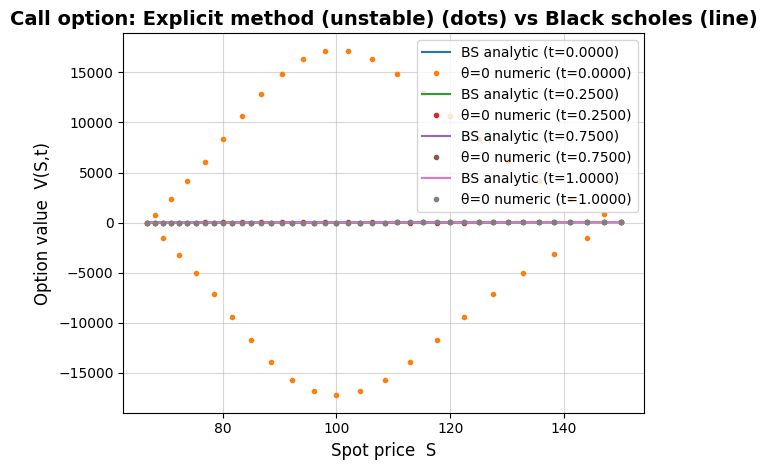

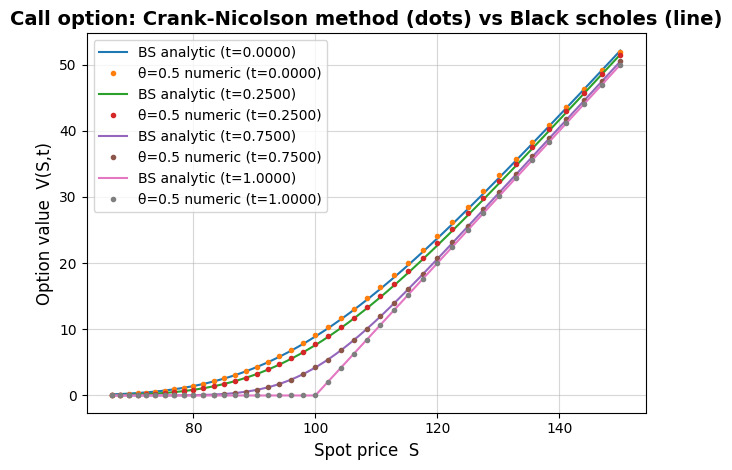

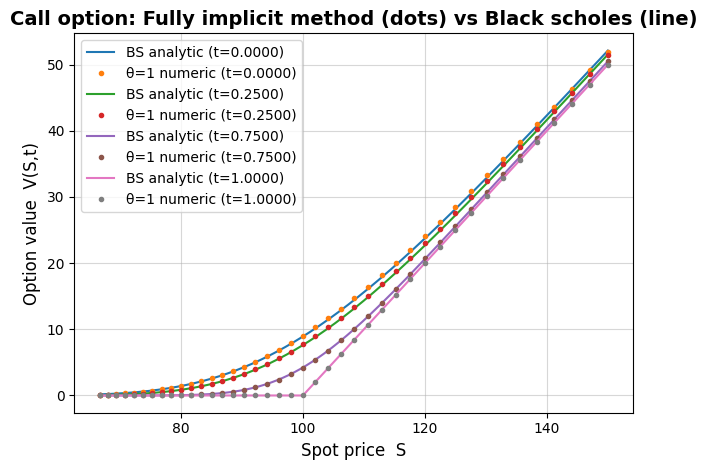

In [78]:
# set up parameters
K = 100
T = 1.0
r = 0.02
sigma = 0.20
S_max = 150
M = 40
N = 90
call = True

plot_num_vs_bs(
    K, T, r, sigma,
    S_max, M, N,
    theta = 0,                    # Crank–Nicolson
    times = [0.0, 0.25, 0.75, 1.0], # calendar times t (years from today)
    call = True,
    times_are = "t",
    title = "Call option: Explicit method (unstable) (dots) vs Black scholes (line)"
)

plot_num_vs_bs(
    K, T, r, sigma,
    S_max, M, N,
    theta=0.5,                    # Crank–Nicolson
    times=[0.0, 0.25, 0.75, 1.0], # calendar times t (years from today)
    call=True,
    times_are="t",
    title = "Call option: Crank-Nicolson method (dots) vs Black scholes (line)"
)

plot_num_vs_bs(
    K, T, r, sigma,
    S_max, M, N,
    theta=1,                    # Crank–Nicolson
    times=[0.0, 0.25, 0.75, 1.0], # calendar times t (years from today)
    call=True,
    times_are="t",
    title = "Call option: Fully implicit method (dots) vs Black scholes (line)"
)


### Comments
It is clear that for the used parameters the $Implicit \ Euler$ and $Crank-Nicolson$ are stable and fit nicely the analytical solution. The same thing cannot be said about $Explicit \ Euler$. Through each iteration in time the errors compound and the price at time 0 completely overshoots; this is consistent with the fact that in term of $u(x,\tau)$ we are solving the Heat equation **forward in time**, but in term of  $V(S,t)$ we are solving BS PDE **backward in time**, so in the last itearation, where the error accumulates the most, we compute the price of the option at $t = 0$.

We are now interested to see how the stability of the hree methods change as we change the $discretization \ scheme$. We create a function that display a 2x2 “stability & accuracy” dashboard for the θ-method (explicit, Crank–Nicolson, implicit). The 4 panel show:

1. **Explicit (unstable) evolution**  
   Runs $\theta=0$ with a time step chosen so that $\lambda=\Delta\tau/\Delta x^{2}>0.5$
   (the explicit stability limit for the heat equation) and plots several snapshots
   $V(x,\tau)$ to illustrate blow-up/instability.

2. **Error norms vs transformed time $\tau$**  
   For $\theta\in\{0,\tfrac{1}{2},1\}$ it computes the $\|\,\cdot\,\|_{\infty}$ and $L^{2}$
   errors versus $\tau$ by comparing the numerical curve to the analytic Black–Scholes price
   at each step. 

3. **Final-time error vs $\lambda$ (dx fixed)**  
   Sweeps target $\lambda$ values, adjusts $N$ accordingly, runs $\theta=0$ and $\theta=\tfrac{1}{2}$,
   and plots the **max error at** $\tau=\tau_{\max}$ (i.e. $t=0$).
   Marks the explicit stability threshold $\lambda=0.5$.

4. **Amplification factor $|G(k)|$**  
   Plots the $Von \ Neumann$ amplification factor magnitude for $\theta\in\{0,\tfrac{1}{2},1\}$:
   
     $$\xi(k)=2\!\left(1-\cos\!\big(k\,\Delta x\big)\right),\qquad
     G(k)=\frac{1-(1-\theta)\,\lambda\,\xi(k)}{1+\theta\,\lambda\,\xi(k)} $$ 
   over wavenumbers $k\in[0,\pi/\Delta x]$. Shows stability ($|G|\le 1$) properties.


In [ ]:
def stability_diagnostic(
    K=100.0,
    T=1.0,
    r=0.02,
    sigma=0.20,
    S_max=150.0,
    M=40,
    call=True,
    # time-stepping choices
    lam_unstable_target=0.55,   # target λ for the explicit-unstable demo (>0.5)
    N_stable=400,              # large enough for clean CN/implicit reference
    # sweep & amplification plot settings
    lam_sweep=(0.1, 1.6, 36),  # (start, stop, num) for λ sweep (target values)
    lam_for_amp=1.0,           # λ to visualize in the amplification-factor plot
    k_samples=500,
    # plotting
    n_snapshots=6,
    figsize=(13, 9),
    font_scale=1.0,
    show=True):

    """
    Produce a 2x2 dashboard showing stability & accuracy of θ-schemes (explicit, CN, implicit)
    for the heat-equation form of Black–Scholes.

    Plots:
      (1) Explicit (θ=0) evolution with λ > 0.5 (unstable)
      (2) Error norms (L∞, L2) vs τ for θ in {0, 0.5, 1}
      (3) Final-time (t=0, TTM=T) error vs λ (explicit vs CN)
      (4) Amplification factor |G(k)| vs wavenumber k for θ in {0, 0.5, 1}
    """

    # helper functions
    def grid_metrics(S_max, K, M, sigma, T):
        x_max = np.log(S_max / K)
        dx = (2.0 * x_max) / M
        tau_max = 0.5 * sigma**2 * T
        return dx, tau_max

    def payoff(S, K, call):
        return np.maximum(S - K, 0.0) if call else np.maximum(K - S, 0.0)

    def compute_errors_once(K, T, r, sigma, S_max, M, N, theta, call):

        """
        Errors vs analytic across all τ steps.
        L2 is simple mean-square on the (uniform-in-x) grid.
        """

        x, tau_grid, history_V, _ = theta_method(K, T, r, sigma, S_max, M, N, theta, call)
        S_grid = K * np.exp(x)

        err_inf = []
        err_L2 = []
        for i, tau in enumerate(tau_grid):
            ttm = 2.0 * tau / (sigma**2)             # time-to-maturity
            if np.isclose(ttm, 0.0, atol=1e-14):
                analytic = payoff(S_grid, K, call)
            else:
                analytic = Black_Scholes_price(S_grid, K, ttm, r, sigma, call)
            diff = history_V[i] - analytic
            err_inf.append(np.max(np.abs(diff)))
            err_L2.append(np.sqrt(np.mean(diff**2)))
        return np.array(tau_grid), np.array(err_inf), np.array(err_L2)

    def amplification_factor(theta, lam, k_vals, dx):

        '''

        '''

        xi = 2.0 * (1.0 - np.cos(k_vals * dx))   # eigenvalue of -Δ_h
        num = 1.0 - (1.0 - theta) * lam * xi
        den = 1.0 + theta * lam * xi
        G = num / den
        return np.abs(G)

    # ----- base metrics -----
    dx, tau_max = grid_metrics(S_max, K, M, sigma, T)

    # pick N_unstable from target λ
    dtau_target = lam_unstable_target * dx**2
    N_unstable = max(3, int(np.ceil(tau_max / dtau_target)))
    lam_unstable_eff = (tau_max / N_unstable) / (dx**2)  # actual λ after ceil

    # global matplotlib tweaks (optional)
    plt.rcParams.update({
        "font.size": 12 * font_scale,
        "axes.titlesize": 14 * font_scale,
        "axes.titleweight": "bold",
        "legend.fontsize": 10 * font_scale,
        "xtick.labelsize": 12 * font_scale,
        "ytick.labelsize": 12 * font_scale,
    })

    # dashboard layout 
    fig, axs = plt.subplots(2, 2, figsize=figsize)
    ax_tl, ax_tr = axs[0]
    ax_bl, ax_br = axs[1]

    # EXPLICIT UNSTABLE EVOLUTION =
    theta_exp = 0.0
    x, tau_grid_u, history_V_u, _ = theta_method(K, T, r, sigma, S_max, M, N_unstable, theta_exp, call=call)
    # choose evenly spaced snapshots
    idxs = np.linspace(0, len(tau_grid_u)-1, min(n_snapshots, len(tau_grid_u)), dtype=int)
    for idx in idxs:
        ax_tl.plot(x, history_V_u[idx], label=f"τ={tau_grid_u[idx]:.4f}")
    ax_tl.set_title(f"Explicit (θ=0) evolution — λ≈{lam_unstable_eff:.3f} (>0.5)")
    ax_tl.set_xlabel("log-moneyness  x = ln(S/K)")
    ax_tl.set_ylabel("V(x, τ)")
    ax_tl.grid(True, alpha=0.4)
    ax_tl.legend()

    # ERROR NORMS VS τ (θ=0, 0.5, 1)
    curves = []
    for theta_val, label in [(0.0, "Explicit"), (0.5, "Crank–Nicolson"), (1.0, "Implicit")]:
        N_use = N_unstable if theta_val == 0.0 else N_stable
        tau_grid_e, err_inf, err_L2 = compute_errors_once(K, T, r, sigma, S_max, M, N_use, theta_val, call)
        ax_tr.plot(tau_grid_e, err_inf, label=f"{label}  L∞")
        ax_tr.plot(tau_grid_e, err_L2, linestyle="--", label=f"{label}  L2")
        curves.append((theta_val, tau_grid_e, err_inf, err_L2))
    ax_tr.set_title("Error norms vs τ")
    ax_tr.set_xlabel("τ")
    ax_tr.set_ylabel("Error")
    ax_tr.set_yscale("log")
    ax_tr.grid(True, alpha=0.4)
    ax_tr.legend(ncols=2)

    # FINAL-TIME ERROR VS λ (EXPLICIT VS CN) 
    lam_start, lam_stop, lam_num = lam_sweep
    lam_targets = np.linspace(lam_start, lam_stop, lam_num)
    lam_eff_list = []
    err_exp_final = []
    err_cn_final = []

    for lam_tgt in lam_targets:
        dtau = lam_tgt * dx**2
        N = max(3, int(np.ceil(tau_max / dtau)))
        lam_eff = (tau_max / N) / (dx**2)
        lam_eff_list.append(lam_eff)

        # explicit
        x_e, _, histV_e, _ = theta_method(K, T, r, sigma, S_max, M, N, 0.0, call=call)
        S_grid_e = K * np.exp(x_e)
        # CN
        x_c, _, histV_c, _ = theta_method(K, T, r, sigma, S_max, M, N, 0.5, call=call)
        S_grid_c = K * np.exp(x_c)

        # final τ is τ_max -> TTM = T
        analytic_e = Black_Scholes_price(S_grid_e, K, T, r, sigma, call)
        analytic_c = Black_Scholes_price(S_grid_c, K, T, r, sigma, call)

        err_exp_final.append(np.max(np.abs(histV_e[-1] - analytic_e)))
        err_cn_final.append(np.max(np.abs(histV_c[-1] - analytic_c)))

    ax_bl.plot(lam_eff_list, err_exp_final, label="Explicit final L∞ error")
    ax_bl.plot(lam_eff_list, err_cn_final,  label="Crank–Nicolson final L∞ error")
    ax_bl.axvline(0.5, linestyle=":", color="k", label="explicit stability λ=0.5")
    ax_bl.set_yscale("log")
    ax_bl.set_title("Final-time error vs λ (dx fixed)")
    ax_bl.set_xlabel("λ = Δτ / Δx²  (effective)")
    ax_bl.set_ylabel("L∞ error at τ=τ_max (TTM=T)")
    ax_bl.grid(True, alpha=0.4)
    ax_bl.legend()

    # AMPLIFICATION FACTOR |G(k)|
    # wavenumbers in [0, π/dx]
    k_vals = np.linspace(0.0, np.pi/dx, k_samples)
    for theta_val, label in [(0.0, "Explicit θ=0"), (0.5, "CN θ=0.5"), (1.0, "Implicit θ=1")]:
        Gmag = amplification_factor(theta_val, lam_for_amp, k_vals, dx)
        ax_br.plot(k_vals, Gmag, label=label)
    ax_br.axhline(1.0, color="red", linestyle=":", linewidth=1.2, label="|G|=1") 
    ax_br.set_title(f"Amplification factor |G(k)|  (λ={lam_for_amp})")
    ax_br.set_xlabel("wavenumber k")
    ax_br.set_ylabel("|G(k)|")
    ax_br.grid(True, alpha=0.4)
    ax_br.legend()

    plt.tight_layout()
    if show:
        plt.show()
    # return handles for further tweaking/saving
    return fig, (ax_tl, ax_tr, ax_bl, ax_br)


### implementation: 

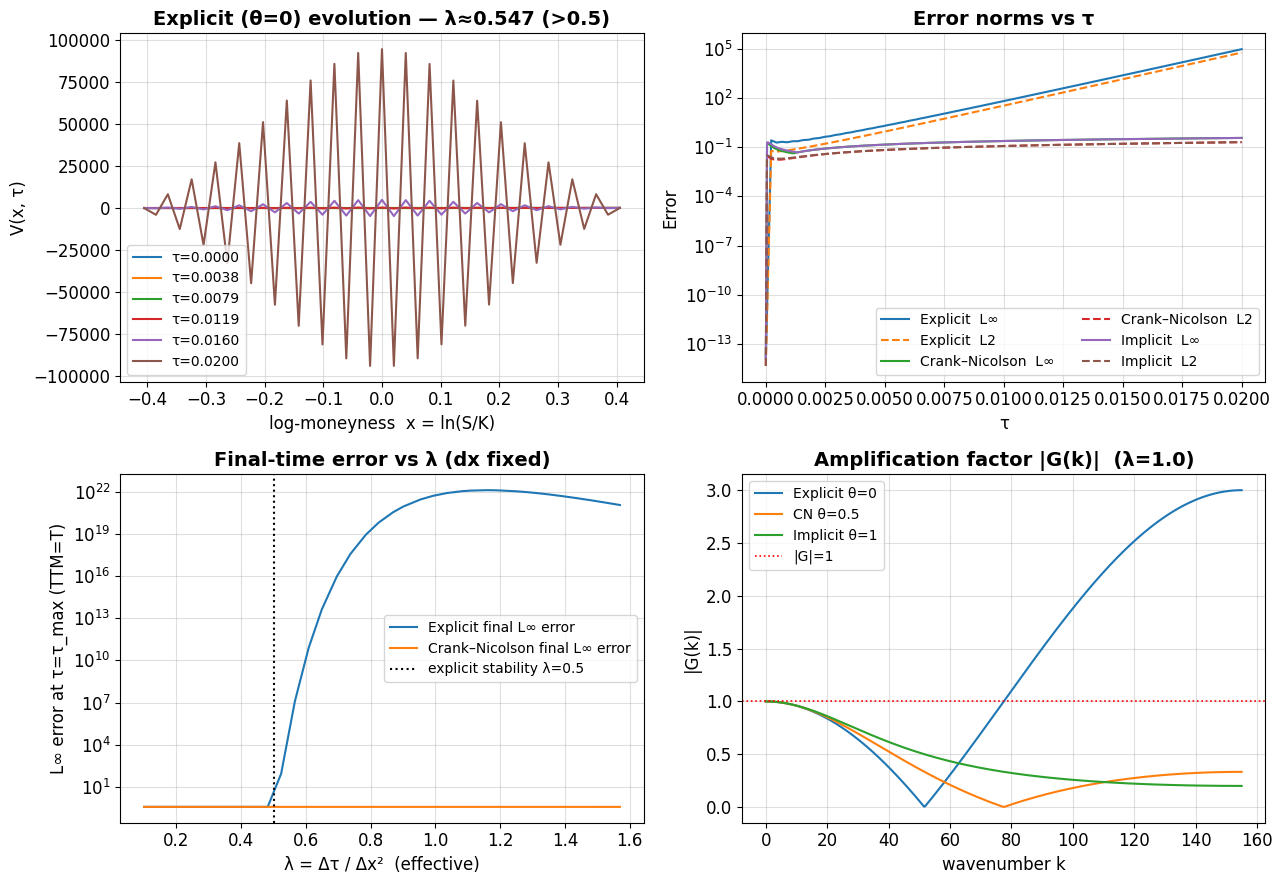

(<Figure size 1300x900 with 4 Axes>,
 (<Axes: title={'center': 'Explicit (θ=0) evolution — λ≈0.547 (>0.5)'}, xlabel='log-moneyness  x = ln(S/K)', ylabel='V(x, τ)'>,
  <Axes: title={'center': 'Error norms vs τ'}, xlabel='τ', ylabel='Error'>,
  <Axes: title={'center': 'Final-time error vs λ (dx fixed)'}, xlabel='λ = Δτ / Δx²  (effective)', ylabel='L∞ error at τ=τ_max (TTM=T)'>,
  <Axes: title={'center': 'Amplification factor |G(k)|  (λ=1.0)'}, xlabel='wavenumber k', ylabel='|G(k)|'>))

In [51]:
stability_diagnostic()

### Comments

#### Top-left: Explicit ($\theta=0$) with $\lambda \approx 0.547 (>0.5)$

- The solution blows up with rapidly growing oscillations.  
- This is the classic explicit heat-scheme stability limit: when
  $
    \lambda=\frac{\Delta\tau}{\Delta x^{2}}>\tfrac12,
  $
  the von Neumann factor exceeds 1 for high $k$ modes, so round-off and initial kinks are amplified.


#### Top-right: Error norms vs transformed time $\tau$

- **Explicit** errors both $L_\infty$ and $L_2$ grow quickly and diverge.  
- Crank–Nicolson $\theta=\frac{1}{2}$ and Implicit $\theta=1$ remain flat/small $\Rightarrow$ $unconditional \ stability$.  
- The small spike near $\tau\approx 0$ comes from the payoff kink (non-smooth initial data). Implicit damps it more than CN (CN is A-stable but not L-stable).


#### Bottom-left — Final-time error vs $\lambda$ (fixed $\Delta x$)

- **Explicit** is fine for $\lambda<0.5$, then error explodes as $\lambda\to 0.5^{+}$.  
- **CN** error is essentially insensitive to $\lambda$ (stability), and the plateau indicates spatial/boundary truncation dominates once time error is small.


#### Bottom-right — Amplification factor $|G(k)|$ at $\lambda=1$

- **Explicit:** $|G|>1$ for a wide band of high wavenumbers $\Rightarrow$ instability.  
- **CN:** $|G|<1$ but tends to 1 for large $k$ $\Rightarrow$ little high-frequency damping (can cause mild oscillations for nonsmooth data).  
- **Implicit:** strongest damping, $|G|=\frac{1}{1+\lambda\,\xi}$, rapidly suppresses high-$k$ noise.

### b) **Price an American put with the theta method using $Brennan-Schwartz$ PSOR. Compute and visualize $\Delta$ and $\Gamma$ of an American put in the continuation region and compare it with the greeks of a European put.**

We now need to price an American put option. We keep unchanged the change of variable and the Right boundary conditions as in the European case but we change the Left boundary condition from $Ke^{r(T-t)}$ to simply $K$ since the American put option can be early exercise. Lastly we take care of the early exercise using $Brennan-Schwartz$ projection:

**Brennan–Schwartz projection**: 
In each time step we continue to use the theta method to solve the diffusion equation, but then we take $u(x,\tau_n)$ and transform it to $V(S(x),t_n(\tau_n))$ and project it:
$$
V(S(x),t_n(\tau_n))=K\,e^{-\alpha x-\alpha^{2}\tau_{n}}\,u(x,\tau_n),\qquad
V(S(x),t_n(\tau_n))^*\leftarrow \max\!\bigl(V(S(x),t_n(\tau_n)),\,\text{payoff}(S(x))\bigr)
$$
This is the way to check for the early exercise. Indeed, we know that the Continuation Value here denoted as $V(S(x),t_n(\tau_n))$ satisfies BS PDE and can be obtained via Finite Difference, but we need to compare it with the immediate payoff to check if early exercise is optimal. Once we have obtained $V(S(x),t_n(\tau_n))^*$ at a given time for each point on the $S(x)$ grid we then return to $u^*(x,\tau)$, that will be used as an input of the next iteration. 



In [81]:
def american_theta_method(K, T, r, sigma, S_max, M, N, theta, call=False):

    """
    Theta-method + Brennan–Schwartz projection for American option.
    OUTPUT: x, tau_grid, history_V, V_final.
    """
    
    # 1) grids in log-space x and transformed time tau
    x_max = np.log(S_max/K)
    x_min = -x_max
    dx = (x_max - x_min)/M
    x = np.linspace(x_min, x_max, M+1)
    tau_max = 0.5 * sigma**2 * T
    dtau = tau_max / N
    tau_grid = np.linspace(0, tau_max, N+1)

    # 2) similarity‐transform parameters
    alpha = (1 - r/(0.5*sigma**2)) / 2
    lam = dtau / dx**2
    size = M - 1  # number of interior points

    # 3) payoff in x-space (normalized by K)
    payoff = np.maximum(np.exp(x)-1, 0) if call else np.maximum(1-np.exp(x), 0)

    # 4) initial condition u = e^{-αx} * payoff
    u = np.exp(-alpha*x) * payoff

    # 5) build constant matrices A (implicit) and B (explicit) for θ‐method
    main_A = (1 + 2*theta*lam) * np.ones(size)
    off_A  =    -theta*lam   * np.ones(size-1)
    A = np.diag(main_A) + np.diag(off_A, 1) + np.diag(off_A, -1)

    main_B = (1 - 2*(1-theta)*lam) * np.ones(size)
    off_B  =  (1-theta)*lam      * np.ones(size-1)
    B = np.diag(main_B) + np.diag(off_B, 1) + np.diag(off_B, -1)

    # helper to go between u and V
    exp_fac = lambda x_val, tau: K * np.exp(-alpha*x_val - alpha**2 * tau)

    # 6) storage
    history_V = []
    V = exp_fac(x, 0) * u
    history_V.append(V.copy())

    # 7) time‐stepping
    for n in range(1, N+1):
        tau_prev, tau = tau_grid[n-1], tau_grid[n]

        disc_prev = np.exp(-r * (2 * tau_prev / sigma**2))
        disc = np.exp(-r * (2 * tau / sigma**2))  # discount factor in transformed time
        
        if call:
            u_left_prev = 0.0
            u_left      = 0.0
            u_right_prev = np.exp(-alpha * x_max) * (np.exp(x_max) - disc_prev)
            u_right      = np.exp(-alpha * x_max) * (np.exp(x_max) - disc)
        else:  # put
            u_left_prev = np.exp(-alpha * x_min) * disc_prev
            u_left      = np.exp(-alpha * x_min) * disc
            u_right_prev = 0.0
            u_right      = 0.0


        # extract interior
        u_int = u[1:-1].copy()

        # 7a) form RHS = B @ u_int plus boundary contributions
        rhs = B.dot(u_int)
        rhs[0]   += (1-theta)*lam * u_left_prev  + theta*lam * u_left
        rhs[-1]  += (1-theta)*lam * u_right_prev + theta*lam * u_right

        # 7b) step
        if theta == 0.0:
            u_new_int = rhs
        else:
            u_new_int = np.linalg.solve(A, rhs)

        # 7c) reassemble u
        u[1:-1] = u_new_int
        u[0], u[-1] = u_left, u_right

        # 7d) back to V and **project** onto payoff
        V = exp_fac(x, tau) * u
        V = np.maximum(V, K * payoff)    # ←— Brennan–Schwartz projection

        # 7e) transform back to u for next step
        u = V / exp_fac(x, tau)

        history_V.append(V.copy())

    return x, tau_grid, np.array(history_V), V

We now need to compute $\Delta$ and $\Gamma$ of the American option and compare them with the European one. We start by 
calling $\texttt{american\_theta\_method}$ to obtain the history $\{V(\cdot,\tau_n)\}_{n=0}^{N}$ on a log–price grid \(x\), where $ S(x)=K e^{x}, \tau=\tfrac12\sigma^2 (T-t).$ The User is allowed to input a $\texttt{times\_to\_maturity}$ list indicating which are the dates the user is interested in to see a snapshot of the greeks. Since the $\tau$ grid may not contain the desired residual time $\tau(t_{\text{res}})$ in $\texttt{times\_to\_maturity}$, we interpolate along $\tau$ at $ \tau_{\text{target}} \;=\; \tfrac12 \sigma^2\, t_{\text{res}}, $ to get the American price vector $V_{\text{AM}}(S, t_{\text{res}})$. Since we are asked to compute the greeks in the continuation region we create a $Boolean-Mask$ to detect for which prices on the grid it is optimal to early exercise: 
$$ \mathcal{C} \;=\; \{\, i:\; V_{\text{AM}}(S_i, t_{\text{res}})\approx \text{payoff}(S_i)\,\}.$$
We will use this mask later on. We smooth pricces along $x$ using $Savitzky–Golay$ filter, and we use the smoothed prices to compute the derivatives with respect to $x$ using the Central Difference Estimator. Once we have obtained $ V_x \equiv \frac{\partial V}{\partial x}, V_{xx} \equiv \frac{\partial^2 V}{\partial x^2} $ we map $x$–derivatives to $S$–greeks using $S=K e^{x}$ and $\dfrac{\partial}{\partial S}=\dfrac{1}{S}\dfrac{\partial}{\partial x}$, which using the chain rule deliver:
$$
{\;\Delta \;=\; \frac{\partial V}{\partial S} \;=\; \frac{V_x}{S}\;},\qquad
\;\Gamma \;=\; \frac{\partial^2 V}{\partial S^2}
   \;=\; \frac{1}{S^2}\bigl(V_{xx}-V_x\bigr).
$$

We then compute analitically $\Delta_{\text{EU}},\Gamma_{\text{EU}}$ from Black–Scholes. Lastly we need to decide which greeks do we desire to plot, the final mask is the union of:
   - **Edges:** first/last ignore_boundary_pts. (More on this in the comments)
   - **Early–exercise side:** The mask $\mathcal{C}$.
   - **Optional right–tail clip:** (usually deisrable to avoid long right tail coming from $S_max$ in FD-method)
     - $auto$ : mask $S>S_{\text{cut}}$, where $S_{\text{cut}}$ is chosen from the EU $\Gamma$ threshold "gamma_floor" and expanded by "right_buffer".
     - $fixed$ : mask $S>S_{\max}^{\text{plot}}$ (provided by the user).
   
   Values in the mask are set to NaN (not rendered). 


In [82]:
def compare_delta_gamma(
    K, T, r, sigma, S_max, M, N, theta,
    call=False, times_to_maturity=None,
    tol_rel=5e-5,          # detect V ≈ payoff
    dilate=6,              # widen the masked exercise band
    ignore_boundary_pts=100,
    sg_poly=3, sg_cap=61,
    # right-tail clipping controls:
    clip_right=None,       # None | 'auto' | 'fixed'
    S_max_plot=None,       # used if clip_right == 'fixed'
    gamma_floor=1e-5,      # used if clip_right == 'auto'
    right_buffer=0.12
):
    """
    Plot Δ and Γ, masking ONLY the early-exercise side.
    Right-tail clipping is optional (off by default).
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import norm
    from scipy.signal import savgol_filter
    from scipy.interpolate import interp1d

    #  EU greeks (for comparison / optional auto-clip) 
    def _bs_delta_gamma(S, K, T_res, r, sigma, call=True):
        S = np.maximum(np.asarray(S), 1e-16)
        if T_res <= 0:
            delta = np.where(S > K, 1.0, 0.0) if call else np.where(S < K, -1.0, 0.0)
            gamma = np.zeros_like(S)
            return delta, gamma
        d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T_res) / (sigma*np.sqrt(T_res))
        delta = norm.cdf(d1) if call else norm.cdf(d1) - 1.0
        gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T_res))
        return delta, gamma

    # -Sove once (no vega bumps) 
    x, tau_grid, H_am, _ = american_theta_method(K, T, r, sigma, S_max, M, N, theta, call)
    S = K * np.exp(x)
    dx = x[1] - x[0]

    if times_to_maturity is None:
        times_to_maturity = [T, T/2, T/4]

    def interp_V(H, tau_grid, sigma_val, t_res):
        tau_target = 0.5 * sigma_val**2 * t_res
        return interp1d(tau_grid, H, axis=0, kind="linear", fill_value="extrapolate")(tau_target)

    def _sg_window(n, poly=3, cap=61):
        w = min(cap, n if n % 2 else n - 1)
        w = max(w, poly + 2)
        if w % 2 == 0: w -= 1
        return max(5, w)

    nS = len(S)
    win_len = _sg_window(nS, poly=sg_poly, cap=sg_cap)
    k_edge = int(max(ignore_boundary_pts, win_len, nS // 12))  # edge band

    cmap = plt.cm.get_cmap('tab10', len(times_to_maturity))
    fig_delta, ax_delta = plt.subplots(figsize=(10, 6))
    fig_gamma, ax_gamma = plt.subplots(figsize=(10, 6))

    for j, t_res in enumerate(times_to_maturity):
        color = cmap(j)

        V_am = interp_V(H_am, tau_grid, sigma, t_res)
        payoff = np.maximum(S - K, 0.0) if call else np.maximum(K - S, 0.0)

        # find payoff contact, then keep ONLY the exercise-side band
        raw = np.isclose(V_am, payoff, rtol=tol_rel, atol=1e-4 * K)
        ex_mask = np.zeros(nS, dtype=bool)
        if call:
            # exercise (if any) is on the RIGHT side for calls
            idx = np.where(raw)[0]
            if idx.size:
                last_touch = idx[-1]
                ex_mask[last_touch:] = True
        else:
            # exercise for puts is on the LEFT side
            if np.any(raw):
                first_non_touch = np.where(~raw)[0][0] if np.any(~raw) else nS
                ex_mask[:first_non_touch] = True

        # dilate the chosen side only
        if dilate > 0 and np.any(ex_mask):
            ker = np.ones(2 * dilate + 1, dtype=int)
            ex_mask = np.convolve(ex_mask.astype(int), ker, mode='same') > 0

        # smooth price, then central differences in x
        V_s = savgol_filter(V_am, window_length=win_len, polyorder=sg_poly, mode="interp")
        Vx  = np.gradient(V_s, dx, edge_order=2)
        Vxx = np.gradient(Vx,  dx, edge_order=2)

        Delta_am = Vx / S
        Gamma_am = (Vxx - Vx) / (S**2)

        # EU for comparison (and optional auto right-clip)
        Delta_eu, Gamma_eu = _bs_delta_gamma(S, K, t_res, r, sigma, call=call)

        # --- assemble final mask
        mask = np.zeros(nS, dtype=bool)
        mask[:k_edge]  = True
        mask[-k_edge:] = True
        mask |= ex_mask

        if clip_right == 'auto':
            idx = np.where(Gamma_eu > gamma_floor)[0]
            if idx.size:
                S_cut = S[idx[-1]] * (1.0 + right_buffer)
                mask |= (S > S_cut)
        elif clip_right == 'fixed' and S_max_plot is not None:
            mask |= (S > float(S_max_plot))
        # else: no right clipping

        # apply mask
        def _masked(a):
            b = a.copy()
            b[mask] = np.nan
            return b

        ax_delta.plot(S, _masked(Delta_eu), color=color, linestyle='-',  label=f"t={t_res:.3f}y EU")
        ax_delta.plot(S, _masked(Delta_am), color=color, linestyle='--', label=f"t={t_res:.3f}y AM")
        ax_gamma.plot(S, _masked(Gamma_eu), color=color, linestyle='-',  label=f"t={t_res:.3f}y EU")
        ax_gamma.plot(S, _masked(Gamma_am), color=color, linestyle='--', label=f"t={t_res:.3f}y AM")

    for ax, ttl, yl in [
        (ax_delta, 'Delta: American (--) vs European (-)', 'Delta'),
        (ax_gamma, 'Gamma: American (--) vs European (-)', 'Gamma'),
    ]:
        ax.set_xlabel('S',fontsize=12)
        ax.set_ylabel(yl, fontsize=12) 
        ax.set_title(ttl, fontsize = 14, weight = 'bold')
        ax.grid(True)
        ax.legend(ncol=2, fontsize=9)

    plt.show()


### Implementation

C:\Users\mscb1\AppData\Local\Temp\ipykernel_30276\1779617839.py:58: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10', len(times_to_maturity))


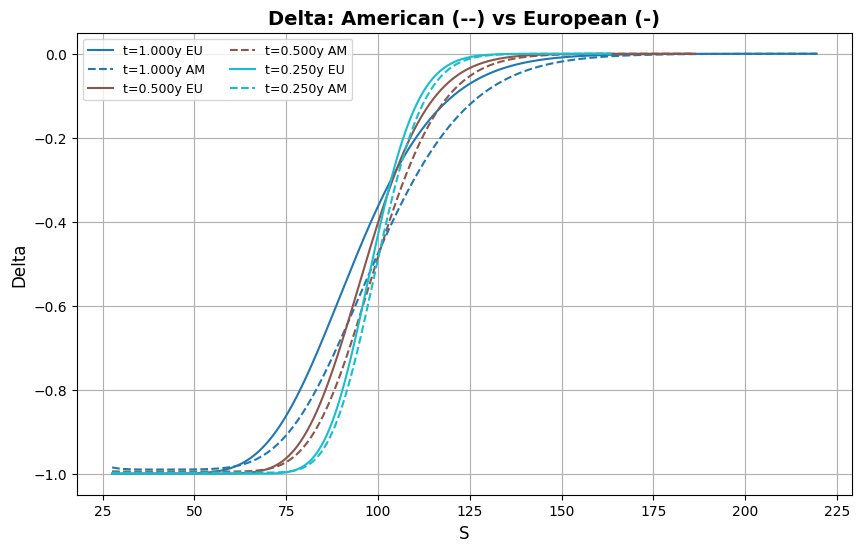

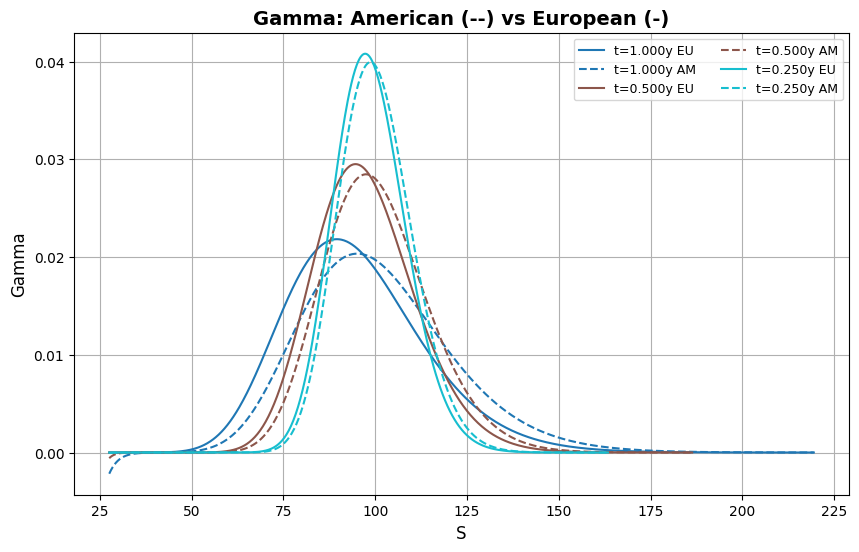

In [83]:
compare_delta_gamma(
    K=100, T=1.0, r=0.05, sigma=0.2,
    S_max=500, M=1200, N=2400, theta=0.5, call=False,
    tol_rel=5e-5, dilate=6, ignore_boundary_pts=120,
    sg_poly=3, sg_cap=61,
    clip_right='auto', gamma_floor=1e-5, right_buffer=0.12
)

### Comments
As we would have expected the $\Delta$ and $\Gamma$ of the American option approach the one of the European as we approach maturity; this happens because the Early Exercise Premium erodes as we appraoch maturity and so both the premium and the greeks of the American Option approach the European one. We observe that the Delta of the American Option is always more negative then the Delta of the European, expecially when further from maturity, this occurs because a decrease may trigger an early exercise and deliver an immediate payoff while for a European this increases the expected payoff but has to go through the discont factor (which can be $\ll 1$, when rates are high or we are very further from maturity). The Gamma instead is tilted to the right with respect to the European this is the effect of the early exercise boundary. By the $smooth \ pasting$ condition the American Option needs to achieve a $\Delta = -1$ and a $\Gamma = 0$ on the boundary that pushes curvature to build to the right, typically making the American $Γ$ peak slightly right of the EU peak.

**Artifacts**: A few issues need to be commented in these plots. The Delta should alaways be more Negative than the European one, even on the left tail. Secondly the Gamma is always positive. Both of these are numerical artifacts, which in general appear in the greeks as we approach the early exercise boundary. To avoid visually these artifacts you can play with the $\texttt{ignore\_boundary\_pts}$ argument cutting the continuation region when these artifacts start to manifest. 

# Exercise 3 

### a) **Assuming $Bates$ Stochastic-Volatility-Jump diffusion model, Price an American put Option using $Longstaff \ and \ Schwartz$ Least Squares Monte Carlo method via polynomial regressions.**

In $Bates$ SVJ model under $\mathbb{Q}$, the **price** and **variance** follow

$$
\frac{dS_t}{S_{t-}} = \big( r - q - \lambda \kappa_J \big)\,dt + \sqrt{v_t}\,dW_{1,t} + (J-1)\,dN_t,
$$

$$
dv_t = \kappa\big(\theta - v_t\big)\,dt + \sigma_v \sqrt{v_t}\, dW_{2,t},
$$

$$
\mathrm{corr}(dW_{1,t}, dW_{2,t}) = \rho.
$$

- $r$: risk-free rate, $q$: dividend yield.  
- $N_t$: Poisson process with intensity $\lambda > 0$.  
- Jumps are **multiplicative**: at a jump time, $S_t = S_{t-}\,J$.  
  We set $J=\exp(Y)$ with $Y\sim \mathcal N(\mu_J,\sigma_J^2)$ (equivalently, $J$ is lognormal with parameters $\mu_J,\sigma_J$).  
- The **jump compensator** is

$$
\kappa_J = \mathbb{E}[J-1] = e^{\mu_J+\tfrac12\sigma_J^2}-1,
$$

so the drift is adjusted by $-\lambda \kappa_J$ to keep discounted prices as martingales.

We create a function that simulates with **Euler full-truncation** for $v_t$ and **Euler-log** for $S_t$:

- Variance step (full truncation):

$$
v_{t+\Delta t} = max\Big(v_t + \kappa\big(\theta - \max(v_t,0)\big)\Delta t + \sigma_v \sqrt{\max(v_t,0)}\,\Delta W_2,0\Big).
$$

- Price step (explicit Euler-log, using the variance at the start of the step):

$$
S_{t+\Delta t } = S_t \cdot \exp\!\Big(\big(r-q-\lambda\kappa_J - \tfrac12\,\max(v_t,0)\big)\Delta t + \sqrt{\max(v_t,0)}\,\Delta W_1\Big)\cdot \prod_{k=1}^{\Delta N} J_k,
$$

with $\Delta N \sim \mathrm{Poisson}(\lambda\Delta)$ and $J_k=\exp(Y_k)$, $Y_k\sim \mathcal N(\mu_J,\sigma_J^2)$.

(Equivalently, $\prod_{k=1}^{\Delta N} J_k = \exp(Z)$ with $Z \mid \Delta N=K \sim \mathcal N(K\mu_J, K\sigma_J^2)$.)

We also create a function that plots the trajectories. 


In [84]:
def simulate_Bates(S_0: float,
                   v_0: float,
                   r: float,
                   q: float,
                   kappa: float,
                   theta: float,
                   sigma_v: float,
                   rho: float,
                   lam: float,
                   mu_j: float,
                   sigma_j: float,
                   T: float,
                   steps: int,
                   n_paths: int):
    '''
    Simulates Bates SVJ (under Q). Returns (S, V), each with shape (n_paths, steps+1).
    Rows = scenarios, columns = time steps
    '''
    S= np.zeros((n_paths,steps+1))
    V= np.zeros((n_paths,steps+1))
    S[:,0]=S_0
    V[:,0]=v_0
    dt = T/steps

    jump_comp = lam * (np.exp(mu_j + 0.5*sigma_j**2) - 1)
    for t in range(1,steps+1):

        Z1 = np.random.normal(size=n_paths)
        Z2 = np.random.normal(size=n_paths)
        dW1 = np.sqrt(dt) * Z1
        dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho ** 2) * Z2)

        v_prev = V[:, t - 1]
        v_next = v_prev + kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * dW2
        v_next = np.maximum(v_next, 0.0)
        V[:, t] = v_next

        dN = np.random.poisson(lam * dt, size=n_paths)
        jump_multiplier = np.ones(n_paths)
        for i, k in enumerate(dN):
            if k > 0:
                Jumps = np.random.lognormal(mu_j, sigma_j, size=k)
                jump_multiplier[i] = np.prod(Jumps)

        drift = (r - jump_comp - 0.5 * v_prev - q) * dt
        diffusion = np.sqrt(v_prev) * dW1
        S[:, t] = S[:, t - 1] * np.exp(drift + diffusion) * jump_multiplier

    return S, V

def Visualize_trajectories(trajectories, T: float):
    '''Plots the trajectories.'''
    arr = np.array(trajectories)
    n_trajectories, n_steps = arr.shape
    t = np.linspace(0.0, T, n_steps)

    plt.figure(figsize=(12, 6))
    for i in range(n_trajectories):
        plt.plot(t, arr[i])

    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.title("Bates Model Trajectories", fontsize=14, weight='bold')
    plt.grid(True)
    plt.show()



### Implementation

In [85]:
S_0 = 100.0   
v_0 = 0.2     
r = 0.1
q = 0.04
kappa = 1.8
theta = 0.04
sigma_v = 0.45
rho = -0.7
lam = 0.10
mu_j = -0.2
sigma_j = 0.10
T = 1.0
steps  = 252*2
n_paths = 5

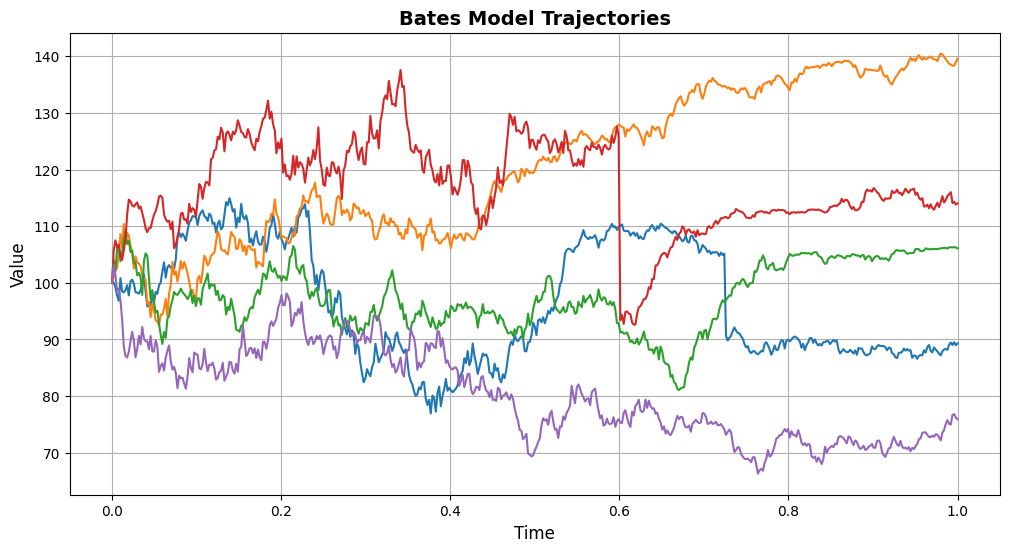

In [107]:
trajectories, _ = simulate_Bates(S_0, v_0, r, q, kappa, theta, sigma_v, rho, lam, mu_j, sigma_j, T, steps, n_paths)
Visualize_trajectories(trajectories, T)

We want to price an American option under simulated price paths using the $Longstaff–Schwartz$ method. We start by calling "simulate_bates" to obtain the simulated trajectories of the underlying asset. At maturity $T$ we must exercise, so
$$
CF^{(i)}_T = \text{payoff}\big(S_T^{(i)}\big).
$$

Then for $t = T-\Delta t, \dots, 0$ we proceed backwards:

1. Discount the future cashflows by one step:
$$
CF^{(i)}_t = e^{-r\Delta t} \, CF^{(i)}_{t+\Delta t}.
$$

2. Identify the in-the-money paths: 
$$
\mathcal{I}_t = \{ i : \text{payoff}(S_t^{(i)}) > 0 \}.
$$

3. On these paths, regress the discounted cashflows on a polynomial basis of rank $p_d$ of $S_t$ (Theoretically it would be more correct to include in the regression also the volatility, but practically for plain vanilla American option it makes no significant difference):
$$
CF^{(i)}_t \approx \hat{C}(S_t^{(i)}) = \sum_{j=0}^{p_d} \beta_j \, (S_t^{(i)})^j.
$$ 
4. Compare immediate exercise vs continuation value:
$$
\text{imm\_val} = \text{payoff}(S_t^{(i)}), \quad
\text{cont\_val} = \hat{C}(S_t^{(i)}).
$$

5. If $\text{imm\_val} > \text{cont\_val}$, overwrite the cashflow:
$$
CF^{(i)}_t = \text{imm\_val}.
$$ 
Otherwise keep the discounted continuation value. Finally, in the last iteration the option value at time $0$ is the average across all paths:
$$
\text{Price} = \frac{1}{N_{\text{sim}}} \sum_{i=1}^{N_{\text{sim}}} CF^{(i)}_0.
$$


In [ ]:
def LSCM_regression(trajectories, 
                    K: float,
                    T: float,
                    r: float,
                    p_d: int, 
                    call=False):
    ''' 
    price an American option using Least-Squares Monte Carlo where the Continuation Value is computed 
    via a polynomial regression.
    '''
    
    N_sim, steps = trajectories.shape
    dt = T / (steps - 1)
    a = np.exp(r * dt)


    payoff = np.maximum(trajectories - K, 0) if call  else np.maximum(K - trajectories, 0)

    # Cashflow matrix holding the optimal cashflow at each time (discounted only back to that time)
    CF = np.zeros_like(payoff)
    CF[:, -1] = payoff[:, -1] # at maturity: exercise if ITM

    # Backward induction
    for t in range(steps - 2, -1, -1):
        # Discount one step the already-optimized future cashflows
        CF[:, t] = CF[:, t+1] / a

        # Consider only paths that are ITM at time
        itm = payoff[:, t] > 0
        if not np.any(itm):
            continue
        
        # Regress discounted future cashflows on a polynomial of S_t (scaled by K for conditioning)
        Y_reg = CF[itm, t]      # continuation value proxy (already discounted one step)
        S_t = trajectories[itm, t]
        scaled_prices = S_t/K
        X_reg = np.vander(scaled_prices, p_d+1, increasing=True) # [1, x, x^2, ..., x^p_d]

        # Solve least-squares (use ridge if needed for stability)        
        coeffs = np.linalg.lstsq(X_reg, Y_reg, rcond=None)[0] 
        cont_val = X_reg.dot(coeffs)

        # Immediate exercise value
        imm_val = payoff[itm, t]

        # Exercise decision (replace CF at time t on ITM paths accordingly)
        exercise = imm_val > cont_val
        CF[itm, t] = np.where(exercise, imm_val, CF[itm, t])

    price = np.mean(CF[:, 0])
    return price


### Implementation
We run LSMC to price an ATM American call option.

In [ ]:
# set up parameters
S_0 = 100.0
K = 100.0   
v_0 = 0.2     
r = 0.1
q = 0.04
kappa = 1.8
theta = 0.04
sigma_v = 0.45
rho = -0.7
lam = 0.10
mu_j = -0.2
sigma_j = 0.10
T = 1.0
steps  = 252*2
n_paths = 100000

In [66]:
trajectories, _ = simulate_Bates(S_0, v_0, r, q, kappa, theta, sigma_v, rho, lam, mu_j, sigma_j, T, steps, n_paths)
LSCM_regression(trajectories, K, T, r, 3, call=True)

15.353332054450291

### b) **Introduce in $Bates$ dynamics discrete dividends in the form of deterministic dividend payout ratio. Use $LSMC$ to obtain the optimal optimal stopping distribution for an ATM call and comment it.**

We start by removing the continuous dividend yield ($q=0$).To introduce discrete dividends we require the user to imput the dividend schedule of the underlying in the form of a dictionary (dict {time of dividend: dividend payout ratio}). In Particular in the time grid $t_k = k\,\Delta t$ with $\Delta t = T/\text{steps}$ and a dividend profile $\{(\tau_m, y_m)\}_{m=1}^M$, where at ex-date $\tau_m$ the stock drops by a proportion $y_m \in [0,1)$.

Map ex-dates to grid steps and build a per-step multiplicative factor
$$
k_m = \mathrm{round}\!\left(\frac{\tau_m}{\Delta t}\right), \qquad m=1,\dots,M, \qquad
D_k \;=\; \prod_{m:\,k_m = k}\bigl(1 - y_m\bigr), \qquad k=0,1,\dots,\text{steps}.
$$

Within each step, evolve the price *without dividends* to an intermediate value (using your Bates SVJ update) and then apply the discrete dividend at the step boundary:
$$
\tilde S_k
= S_{k-1}\,
\exp\!\Bigl(\bigl(r - \lambda\kappa_J - \tfrac12\,v_{k-1}\bigr)\Delta t
+ \sqrt{v_{k-1}}\,\Delta W_{1,k}\Bigr)\;
\prod_{j=1}^{\Delta N_k} J_{k,j} \cdot D_k
$$
If no ex-date maps to step $k$, then $D_k = 1$.


In [108]:
def simulate_Bates_discrete_dividends(S_0: float,
                   v_0: float,
                   r: float,
                   dividends_profile: dict,
                   kappa: float,
                   theta: float,
                   sigma_v: float,
                   rho: float,
                   lam: float,
                   mu_j: float,
                   sigma_j: float,
                   T: float,
                   steps: int,
                   n_paths: int):
    '''
    Simulates Bates SVJ with discrete dividends (under Q). Returns (S, V), each with shape (n_paths, steps+1).
    Rows = scenarios, columns = time steps
    '''

    S= np.zeros((n_paths,steps+1))
    V= np.zeros((n_paths,steps+1))
    S[:,0]=S_0
    V[:,0]=v_0

    dt = T/steps
    jump_comp = lam * (np.exp(mu_j + 0.5 * sigma_j**2) - 1.0)

    # Build per-step dividend factor (proportional drops at ex-dates)
    div_factor = np.ones(steps + 1)
    for tau, y in dividends_profile.items():
        k = int(round(tau / dt))
        if 0 < k <= steps:
            div_factor[k] *= max(1.0 - y, 0.0)

    for t in range(1,steps+1):

        Z1 = np.random.normal(size=n_paths)
        Z2 = np.random.normal(size=n_paths)
        dW1 = np.sqrt(dt) * Z1
        dW2 = np.sqrt(dt) * (rho * Z1 + np.sqrt(1 - rho ** 2) * Z2)

        v_prev = V[:, t - 1]
        v_next = v_prev + kappa * (theta - v_prev) * dt + sigma_v * np.sqrt(v_prev) * dW2
        v_next = np.maximum(v_next, 0.0)
        V[:, t] = v_next

        dN = np.random.poisson(lam * dt, size=n_paths)
        jump_multiplier = np.ones(n_paths)
        for i, k in enumerate(dN):
            if k > 0:
                Jumps = np.random.lognormal(mu_j, sigma_j, size=k)
                jump_multiplier[i] = np.prod(Jumps)

        drift = (r - jump_comp - 0.5 * v_prev) * dt
        diffusion = np.sqrt(v_prev) * dW1
        S[:, t] = S[:, t - 1] * np.exp(drift + diffusion) * jump_multiplier * div_factor[t]

    return S, V

### Implementation
We plot Bates SVJ trajectories adding vertical lines showing dividend dates.

In [109]:
#set up parameters
S_0 = 100.0
K = 100.0   
v_0 = 0.2     
r = 0.1
q = 0.04
kappa = 1.8
theta = 0.04
sigma_v = 0.45
rho = -0.7
lam = 0.10
mu_j = -0.2
sigma_j = 0.10
T = 1.0
steps  = 252*2
n_paths = 100000
dividends_profile = {0.5: 0.1, 0.75: 0.1}

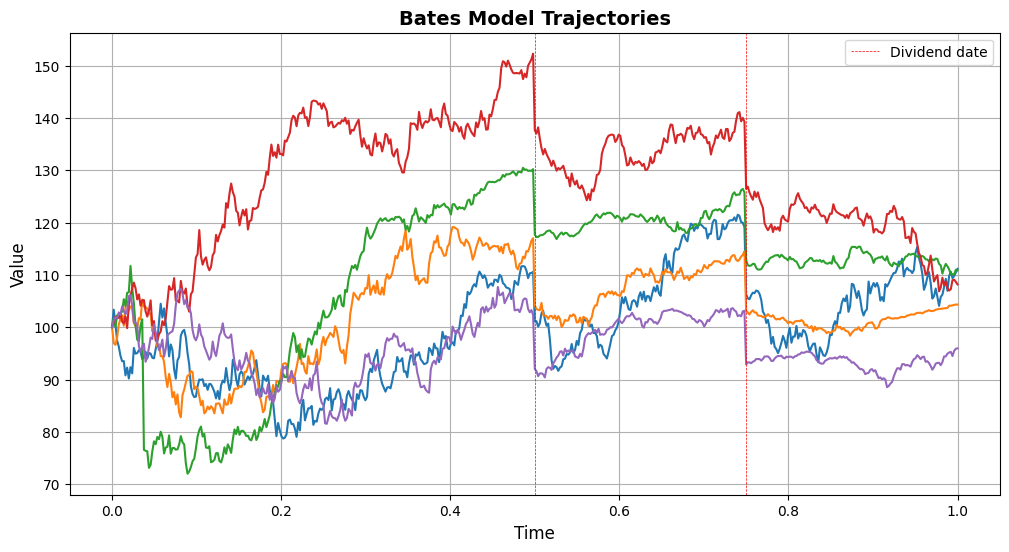

In [113]:
trajectories, _ = simulate_Bates_discrete_dividends(
    S_0, v_0, r, dividends_profile,
    kappa, theta, sigma_v, rho,
    lam, mu_j, sigma_j, T, steps, 5
)

_original_show = plt.show
plt.show = lambda *args, **kwargs: None

Visualize_trajectories(trajectories, T)
plt.show = _original_show

v_lines = list(dividends_profile.keys())

ax = plt.gca()

for xv in v_lines:
    ax.axvline(x=xv, color='r' , linestyle='--', linewidth=0.5, label='Dividend date')

handles, labels = ax.get_legend_handles_labels()

if 'Dividend date' in labels:
    idx = labels.index('Dividend date')
    handles = handles[:idx+1] + [h for h,l in zip(handles,labels) if l!='Dividend date']
    labels = labels[:idx+1] + [l for l in labels if l!='Dividend date']
    ax.legend(handles, labels)

plt.show()

In [ ]:
def LSMC_stopping_times(trajectories, 
                        K: float,
                        T: float,
                        r: float,
                        p_d: int, 
                        call: bool = False):
    """
    Using Monte Carlo paths, return per-path optimal stopping times (in years).
    Paths that never exercise early keep tau = T.
    """
    N_sim, steps = trajectories.shape
    dt = T / (steps - 1)
    a = np.exp(r * dt)

    payoff = np.maximum(trajectories - K, 0) if call else np.maximum(K - trajectories, 0)

    # Cashflows and stopping times
    CF = np.zeros_like(payoff)
    CF[:, -1] = payoff[:, -1]
    tau = np.full(N_sim, T)  # default: exercise at maturity (or never early)

    for t in range(steps - 2, -1, -1):
        # one-step discount of already-optimized future CFs
        CF[:, t] = CF[:, t + 1] / a

        itm = payoff[:, t] > 0
        if not np.any(itm):
            continue

        # regression on ITM paths
        Y_reg = CF[itm, t]
        S_t   = trajectories[itm, t]
        X_reg = np.vander(S_t, p_d + 1, increasing=True)
        coeffs = np.linalg.lstsq(X_reg, Y_reg, rcond=None)[0]
        cont_val = X_reg @ coeffs

        imm_val = payoff[itm, t]
        exercise = imm_val > cont_val

        # write cashflows without chained indexing
        CF[itm, t] = np.where(exercise, imm_val, CF[itm, t])

        # record stopping times: overwrite so earlier (smaller t) wins as we go backward
        idx_itm = np.where(itm)[0]
        to_exercise = idx_itm[exercise]
        tau[to_exercise] = t * dt

    return tau.tolist()


### Implementation

We need to plot the optimal stopping time distribution. While in point 1.b) it made sense to use the empirical historgram to represent the density of the distribution, with 
discrete dividends we expect the probability to mass sistematically around dividend dates, this is why we opt for a probability mass function. In particular, we simulate on a time grid $t_k = k\,\Delta t$ with $\Delta t = T/(\text{steps}-1)$.
For each simulated path $i=1,\dots,N_{\text{sim}}$, the LSMC policy yields an
optimal stopping time
$$
\hat\tau^{(i)} \in \{t_0,t_1,\dots,t_{\text{steps}-1}\}.
$$

The **empirical probability mass function (PMF)** on the grid is
$$
p_k \;=\; \frac{1}{N_{\text{sim}}}\sum_{i=1}^{N_{\text{sim}}}
\mathbf{1}\{\hat\tau^{(i)} = t_k\}, \qquad k=0,\dots,\text{steps}-1,
$$
and $\sum_k p_k = 1$.

Bear in mind that with respect to point 1.b) where we went forward in time and detected the early exericse as the $first \ hitting \ time$, with LSMC we go backward from maturity to inception so the early exercise must be detected in a sense as the $last \ hitting \ time$ in the backward iteration.


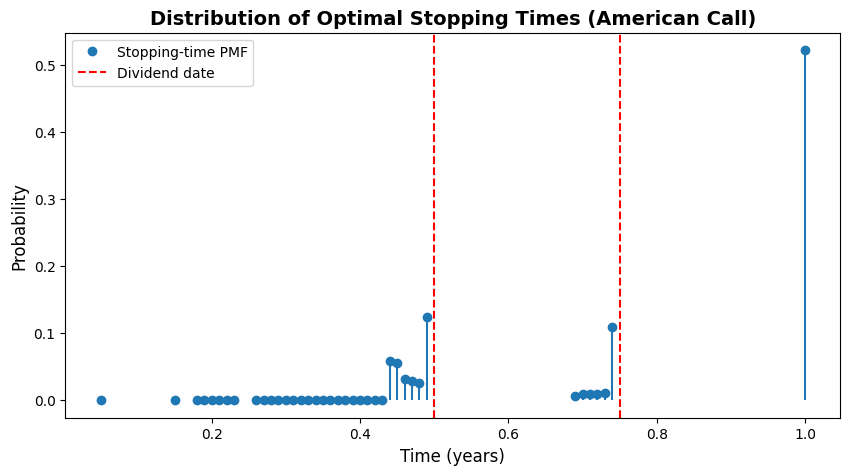

In [12]:
n_paths = 500000
K = 95
steps = 100
dividends_profile = {0.5: 0.03, 0.75: 0.04}

S, _ = simulate_Bates_discrete_dividends(
    S_0, v_0, r, dividends_profile, kappa, theta, sigma_v, rho, lam, mu_j, sigma_j, T, steps, n_paths
)

stopping_times = LSMC_stopping_times(S, K, T, r, 3, call=True)

times, counts = np.unique(stopping_times, return_counts=True)
probs = counts / counts.sum()

fig, ax = plt.subplots(figsize=(10, 5))

# Stem plot of the discrete PMF (no use_line_collection)
markerline, stemlines, baseline = ax.stem(times, probs)
baseline.set_visible(False)                     # hide baseline (was basefmt=" ")

markerline.set_label("Stopping-time PMF")
ax.set_xlabel("Time (years)", fontsize = 12)
ax.set_ylabel("Probability", fontsize = 12)
ax.set_title("Distribution of Optimal Stopping Times (American Call)", fontsize = 14, weight = 'bold')

# Dividend date markers (single legend entry)
for i, xv in enumerate(sorted(dividends_profile.keys())):
    ax.axvline(x=xv, color='r', linestyle='--', linewidth=1.5,
               label='Dividend date' if i == 0 else None)

ax.legend()
plt.show()

### Comments
Predictibly, the pmf spikes before the dividends dates, showing that American call options are exercised systematically before the relase of dividends. This occurs because the Continuation Value drops significantly before the dividend date, so that the immediate payoff is likely to dominate it and trigger an early exercise.

### c) **Assume mulidimensional $Bates$ SVJ dynamics, injecting correlation in price shocks and in the Compound Poisson Processes and price an American worst-of down-and-out option using **Neural** LSMC.**

We need to simulate two assets $S_t^{(1)}, S_t^{(2)}$ with variances $v_t^{(1)}, v_t^{(2)}$ on a grid $t_k=k\,\Delta t$, $\Delta t=T/\text{steps}$. With respect to the unidimensional case, two additional technicalities need to be covered: injecting correlation in the $Brownian \ motions$ of Prices and injecting correlation in the $Compound \ Poisson \ Process$. 

#### Correlated Brownian drivers

We inject correlation in Price shocks:
$$
\begin{pmatrix} dW^{S,1}_t \\ dW^{S,2}_t \end{pmatrix}
\sim \mathcal N\!\left( \begin{pmatrix}0\\0\end{pmatrix},
\begin{pmatrix}
1 & \rho_{\text{price}}\\
\rho_{\text{price}} & 1
\end{pmatrix} dt \right),
$$
obtained in code via a Cholesky factor.

Volatility shocks instead are correlated with their own asset and independent across assets:
$$
dW^{v,i}_t \;=\; \rho_{sv,i}\, dW^{S,i}_t \;+\; \sqrt{1-\rho_{sv,i}^2}\, dZ^{i}_t,\qquad i\in\{1,2\},
$$
with $dZ^{1}_t, dZ^{2}_t$ independent.

#### Jump structure (common co-jumps + idiosyncratic jumps)

Injecting correlation in $Compound \ Poisson \ Process$ is slightly more complicated since we need to inject correlation both in the $Poisson \ Process$ couning jumps and in the log-normal jumps size. Each asset $i$ has total intensity $\lambda_i$. We split it into a **common** part
$$
\lambda_c \;=\; \min(\lambda_1,\lambda_2)\cdot \text{corr\_jumps},
$$
and **idiosyncratic** parts $\lambda^{\text{id}}_1=\lambda_1-\lambda_c$, $\lambda^{\text{id}}_2=\lambda_2-\lambda_c$.

- Common co-jumps arrive with $dN^c_t \sim \text{Poisson}(\lambda_c\,dt)$ and have **correlated sizes**:
  $J^{(i)}=\exp(Y_i)$ where
  $$
  \begin{pmatrix} Y_1\\ Y_2 \end{pmatrix}
  \sim \mathcal N\!\left(
  \begin{pmatrix}\mu_{j,1}\\ \mu_{j,2}\end{pmatrix},
  \begin{pmatrix}
  \sigma_{j,1}^2 & \rho_{\text{jumps}}\sigma_{j,1}\sigma_{j,2}\\
  \rho_{\text{jumps}}\sigma_{j,1}\sigma_{j,2} & \sigma_{j,2}^2
  \end{pmatrix}
  \right).
  $$
- Idiosyncratic jumps arrive with $dN^{\text{id},i}_t \sim \text{Poisson}(\lambda^{\text{id}}_i\,dt)$ and sizes
  $J^{(i)}=\exp(Y_i)$ with $Y_i \sim \mathcal N(\mu_{j,i},\sigma_{j,i}^2)$, independent.

The **jump compensator** for each asset is
$$
\kappa_{J,i} \;=\; \mathbb E[J^{(i)}-1] \;=\; e^{\mu_{j,i}+\tfrac12\sigma_{j,i}^2}-1,
\qquad i\in\{1,2\}.
$$


#### Correlation summary

- $\mathrm{corr}(dW^{S,1}_t, dW^{S,2}_t)=\rho_{\text{price}}$ (price–price).
- $\mathrm{corr}(dW^{v,i}_t, dW^{S,i}_t)=\rho_{sv,i}$, with $dW^{v,1}_t \perp dW^{v,2}_t$ (across volatilities).
- Common co-jumps occur simultaneously with intensity $\lambda_c$; their **sizes** have correlation $\rho_{\text{jumps}}$ as above. Idiosyncratic jumps are independent.


Outside of these added technicalities, we use the usual disctrization as the one-dimensional case.

1. Variance (full truncation Euler, per asset $i$):
$$
v^{(i)}_{k}=max\Big(v^{(i)}_{k-1}
+ \kappa_i\big(\theta_i-\max(v^{(i)}_{k-1},0)\big)\Delta t
+ \sigma_{v,i}\sqrt{\max(v^{(i)}_{k-1},0)}\,\Delta W^{v,i}_k ,0\Big) .
$$

2. Price (Euler–log with start-of-step variance, jumps, and dividends):
$$
S^{(i)}_{k} = S^{(i)}_{k-1}\;
\exp\!\Big( \big(r-\lambda_i\kappa_{J,i}-\tfrac12\,\max(v^{(i)}_{k-1},0)\big)\Delta t
+ \sqrt{\max(v^{(i)}_{k-1},0)}\,\Delta W^{S,i}_k \Big)
\;\times\; J^{(i)}_{k}\;\times\; D^{(i)}_{k},
$$
where $J^{(i)}_{k}$ is the product of all jump multipliers (common and idiosyncratic) occurring in step $k$.


In [115]:
def simulate_multidimensional_Bates(
        S0: tuple,
        v0: tuple,
        r: float,
        dividends_profile: tuple,
        kappa: tuple,
        theta: tuple,
        sigma_v: tuple,
        rho_sv: tuple,
        rho_price: float,
        rho_jumps: float,
        lam: tuple,
        mu_j: tuple,
        sigma_j: tuple,
        corr_jumps: float,
        T: float,
        steps: int,
        n_paths: int):
    
    '''
    Simulates a bidemensional Bates SVJ model trajectories. The output are 4 matricies 
    N x (T+1): the trafectories of the first security, the trajectories of the second secuirty, 
    the volatility process of the first security and the volatility process if the second security. 

    '''

    dt = T / steps

    # Build per-step dividend multipliers
    def build_div_multipliers(div_profile):
        times = np.array(list(div_profile.keys()))
        yields = np.array(list(div_profile.values()))
        step_idxs = np.round(times / dt).astype(int).clip(1, steps)
        mult = np.ones(steps + 1)
        for st, y in zip(step_idxs, yields):
            mult[st] *= (1.0 - y)
        return mult

    div_mult1 = build_div_multipliers(dividends_profile[0])
    div_mult2 = build_div_multipliers(dividends_profile[1])

    # Allocate arrays
    S1 = np.zeros((n_paths, steps+1)); S2 = np.zeros_like(S1)
    V1 = np.zeros((n_paths, steps+1)); V2 = np.zeros_like(V1)
    S1[:,0], S2[:,0] = S0
    V1[:,0], V2[:,0] = v0

    # Cholesky for spot–spot diffusion correlation
    C_price = np.array([[1.0, rho_price],
                        [rho_price, 1.0]])
    L_price = np.linalg.cholesky(C_price)

    # Precompute for jump‐size correlation
    C_jmp = np.array([[1.0, rho_jumps],
                      [rho_jumps, 1.0]])
    L_jmp = np.linalg.cholesky(C_jmp)

    # Determine common and idiosyncratic jump rates
    lam_common = min(lam[0], lam[1]) * corr_jumps
    lam1_idio  = lam[0] - lam_common
    lam2_idio  = lam[1] - lam_common

    for t in range(1, steps+1):
        # draw 4 raw normals per path: [Z1_price, Z2_price, Z1_vol, Z2_vol]
        Z = np.random.normal(size=(n_paths, 4))

        # correlate the two spot shocks
        Zp = Z[:, :2] @ L_price.T
        dW1_p = np.sqrt(dt) * Zp[:,0]
        dW2_p = np.sqrt(dt) * Zp[:,1]

        # build each asset's vol shock with its own rho_sv
        dW1_v = np.sqrt(dt) * (
            rho_sv[0]*Zp[:,0] + np.sqrt(1 - rho_sv[0]**2)*Z[:,2]
        )
        dW2_v = np.sqrt(dt) * (
            rho_sv[1]*Zp[:,1] + np.sqrt(1 - rho_sv[1]**2)*Z[:,3]
        )

        # variance updates (full‐truncation Euler)
        v1_prev, v2_prev = V1[:,t-1], V2[:,t-1]
        v1 = np.maximum(
            v1_prev
            + kappa[0]*(theta[0] - np.maximum(v1_prev,0))*dt
            + sigma_v[0]*np.sqrt(np.maximum(v1_prev,0))*dW1_v,
            0
        )
        v2 = np.maximum(
            v2_prev
            + kappa[1]*(theta[1] - np.maximum(v2_prev,0))*dt
            + sigma_v[1]*np.sqrt(np.maximum(v2_prev,0))*dW2_v,
            0
        )
        V1[:,t], V2[:,t] = v1, v2

        # Poisson counts
        dN_c   = np.random.poisson(lam_common*dt, size=n_paths)
        dN1_i  = np.random.poisson(lam1_idio *dt, size=n_paths)
        dN2_i  = np.random.poisson(lam2_idio *dt, size=n_paths)

        jm1 = np.ones(n_paths)
        jm2 = np.ones(n_paths)

        # apply common jumps (with size‐correlation rho_jumps)
        for i in range(n_paths):
            for _ in range(dN_c[i]):
                z = np.random.normal(size=2)
                z1, z2 = L_jmp @ z
                jm1[i] *= np.exp(mu_j[0] + sigma_j[0]*z1)
                jm2[i] *= np.exp(mu_j[1] + sigma_j[1]*z2)

        # apply idiosyncratic jumps
        for i in range(n_paths):
            if dN1_i[i] > 0:
                jm1[i] *= np.prod(
                    np.random.lognormal(mu_j[0], sigma_j[0], size=dN1_i[i])
                )
            if dN2_i[i] > 0:
                jm2[i] *= np.prod(
                    np.random.lognormal(mu_j[1], sigma_j[1], size=dN2_i[i])
                )

        # jump compensators
        jc1 = lam[0]*(np.exp(mu_j[0] + 0.5*sigma_j[0]**2) - 1)
        jc2 = lam[1]*(np.exp(mu_j[1] + 0.5*sigma_j[1]**2) - 1)

        # drifts & diffusions
        drift1 = (r - jc1 - 0.5*v1_prev)*dt;  diff1 = np.sqrt(v1_prev)*dW1_p
        drift2 = (r - jc2 - 0.5*v2_prev)*dt;  diff2 = np.sqrt(v2_prev)*dW2_p

        # spot updates
        S1[:,t] = S1[:,t-1] * np.exp(drift1 + diff1) * jm1 * div_mult1[t]
        S2[:,t] = S2[:,t-1] * np.exp(drift2 + diff2) * jm2 * div_mult2[t]

    return S1, S2, V1, V2, 



We create a function to plot trajectories of the two securities, adding horizontal dotted lines to show dividend dates. 

In [116]:
def plot_trajectories(
    traj1, traj2,
    label1='Security 1',
    label2='Security 2',
    ax=None,
    show=True
):
    """Plot two sets of trajectories on the same axes"""
    own_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
        own_fig = True

    # Security 1: solid blue
    for path in traj1:
        ax.plot(path, color='blue', alpha=0.6)
    # Security 2: dashed red
    for path in traj2:
        ax.plot(path, color='red', alpha=0.6)

    # dummy lines just for one legend entry each
    ax.plot([], [], color='blue', label=label1)
    ax.plot([], [], color='red', label=label2)
    ax.legend()
    ax.set_xlabel('Step', fontsize = 12)
    ax.set_ylabel('Value', fontsize = 12)
    ax.set_title('Multidimensional Bates trajectories', fontsize = 14, weight = 'bold')
    if own_fig:
        plt.tight_layout()
    if show:
        plt.show()
    return ax



### Implementation

In [117]:
S0 = (100,140)
v0 =(0.14,0.08)
r = 0.03
dividends_profile = ({0.5: 0.1, 1: 0.1},{0.25: 0.07, 0.75: 0.07})
kappa = (0.14,0.25)
theta = (0.17,0.09)
sigma_v = (0.23,0.13)
rho_sv = (-0.3,-0.4)
rho_price = 0.7
rho_jumps = 0.8
lam = (0.2,0.1)
mu_j = (0.12,0.07)
sigma_j = (0.03,0.02)
corr_jumps = 0.9
T = 1.5
steps = 252*2
n_paths = 1

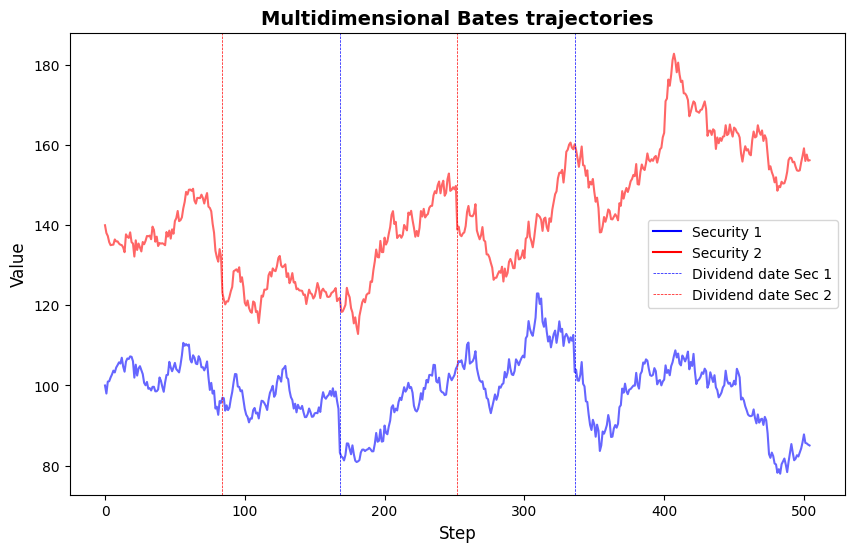

In [123]:
trajectories_1, trajectories_2, _ , _ = simulate_multidimensional_Bates(
    S0, v0, r, dividends_profile,
    kappa, theta, sigma_v,
    rho_sv, rho_price, rho_jumps,
    lam, mu_j, sigma_j, corr_jumps,
    T, steps, n_paths
)

fig, ax = plt.subplots(figsize=(10, 6))

# plot the trajectories without showing
plot_trajectories(
    trajectories_1,
    trajectories_2,
    label1='Security 1',
    label2='Security 2',
    ax=ax,
    show=False
)

# convert dividend times → step indices
v_times_1 = sorted(dividends_profile[0].keys())
v_times_2 = sorted(dividends_profile[1].keys())

# assume `steps` is the number of intervals in your simulation
for i, t in enumerate(v_times_1):
    idx = int(t / T * steps)
    ax.axvline(
        x=idx,
        color='b',
        linestyle='--',
        linewidth=0.5,
        label='Dividend date Sec 1' if i == 0 else None
    )

for i, t in enumerate(v_times_2):
    idx = int(t / T * steps)
    ax.axvline(
        x=idx,
        color='r',
        linestyle='--',
        linewidth=0.5,
        label='Dividend date Sec 2' if i == 0 else None
    )

#  clean up and show
ax.legend()
plt.show()



We now need to price an American option worst-of with a down-and-out barrier using a neural network as the continuation-value regressor, in a backward dynamic programming loop.We take as inputs the two simulated price tensors $S^{(1)}, S^{(2)} \in \mathbb{R}^{N_{\text{sim}} \times \text{steps}}$ and their variances $v^{(1)}, v^{(2)}$ are moved to the chosen device (CPU/GPU). 

We knock out paths when $\min(S^{(1)}_t, S^{(2)}_t) \le H$. The boolean mask $\text{alive}_{i,t}$ enforces the barrier:
$$
\text{alive}_{i,0} = \mathbf{1}\{\min(S^{(1)}_{i,0}, S^{(2)}_{i,0}) > H\}, \qquad
\text{alive}_{i,t} = \text{alive}_{i,t-1} \wedge \big(\min(S^{(1)}_{i,t}, S^{(2)}_{i,t}) > H\big).
$$
All payoffs on knocked-out states are set to $0$.

For the min-option, with $S^{\min}_t = \min(S^{(1)}_t, S^{(2)}_t)$:
$$
\text{payoff}_t =
\begin{cases}
\max(S^{\min}_t - K, 0), & \text{call},\\
\max(K - S^{\min}_t, 0), & \text{put}.
\end{cases}
$$
We initialize the optimal cashflows $CF$ with terminal exercise:
$$
CF_{i,\text{end}} = \text{payoff}_{i,\text{end}}.
$$
A feed-forward MLP approximates the continuation value $\widehat C$:
$$
\widehat{C}_\phi(x_t) \approx \mathbb{E}\!\left[e^{-r\Delta t}\,CF_{t+1} \mid x_t\right],
$$
with architecture $\text{Linear} \to \text{ReLU} \to \cdots \to \text{Linear}(1)$.

**State features** at time $t$ (per selected path):
$$
x_t = \big[t_{\text{rem}},\ \log S^{(1)}_t,\ \log S^{(2)}_t,\ v^{(1)}_t,\ v^{(2)}_t,\ S^{\min}_t - H\big],
$$
where $t_{\text{rem}} = (T - t\Delta t)/T$ is the normalized time-to-maturity (To be even more precise you can add as features the time to dividends of $S^1$ and $S^2$).

The algorithm follows the below iterative procedure from $t=\text{steps}-2,\dots,0$:
1. One-step discount of already-optimized future cashflows:
$$
\text{cont}_t = e^{-r\Delta t}CF_{t+1},\qquad \text{cont}_t \gets 0 \ \text{on} \ \neg\text{alive}_t.
$$
2. Select **in-the-money and alive** samples:
$$
\mathcal{I}_t = \{i:\ \text{alive}_{i,t} = 1,\ \text{payoff}_{i,t} > 0\}.
$$
3. Subsample $\mathcal{I}_t$ to a fixed size (variance control) and build $(x_t, y_t)$ pairs with targets
$$
y_t = \text{cont}_t.
$$
4. Fine-tune the shared network $\widehat{C}_\phi$ for a few epochs at time $t$ using MSE:
$$
\min_\phi \ \frac{1}{B}\sum_{(x_t,y_t)} \big(\widehat{C}_\phi(x_t) - y_t\big)^2.
$$
5. On the subsampled ITM set, compare immediate exercise vs. estimated continuation:
$$
\text{exercise}_{i,t} = \big[\text{payoff}_{i,t} > \widehat{C}_\phi(x_{i,t})\big].
$$
6. Overwrite the discounted continuation with immediate value where optimal:
$$
\text{cont}_{i,t} \gets
\begin{cases}
\text{payoff}_{i,t}, & \text{if } \text{exercise}_{i,t}=1,\\
\text{cont}_{i,t}, & \text{otherwise}.
\end{cases}
$$
7. Set
$$
CF_t = \text{cont}_t.
$$

#### Price estimate

After all the backward iterations are completed, determine the initial price as:
$$
\text{Price} \;\approx\; \frac{1}{N_{\text{sim}}}\sum_{i=1}^{N_{\text{sim}}} CF_{i,0}.
$$



In [ ]:
class ContinuationNet(nn.Module):
    """
    MLP to estimate continuation value; includes time-to-maturity as input.
    """
    def __init__(self, input_dim, hidden_dims=(64, 64, 32)):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(-1)

class LSMSCDataset(Dataset):

    """
    Dataset mapping state vectors to continuation targets.
    """
    
    def __init__(self, states, targets):
        # states: torch.Tensor [N, d], targets: torch.Tensor [N]
        self.states = states
        self.targets = targets

    def __len__(self):
        return self.states.shape[0]

    def __getitem__(self, idx):
        return self.states[idx], self.targets[idx]

def LSMC_neural(trajectories_1, trajectories_2, vol_1, vol_2,
                        K, H, T, r, call=False,
                        hidden_dims=(64,64,32), lr=1e-3,
                        batch_size=4096, subsample_size=10000,
                        fine_tune_epochs=2, device=None):
    
    """
    Improved Neural LSMC:
    - Single network reused
    - Time-to-maturity as feature
    - Subsample ITM paths
    - GPU-resident tensors
    - Fewer fine-tune epochs and larger batch size
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") if device is None else device

    traj1 = torch.tensor(trajectories_1, dtype=torch.float32, device=device)
    traj2 = torch.tensor(trajectories_2, dtype=torch.float32, device=device)
    v1    = torch.tensor(vol_1,          dtype=torch.float32, device=device)
    v2    = torch.tensor(vol_2,          dtype=torch.float32, device=device)
    
    N_sim, steps = trajectories_1.shape
    dt = T / (steps - 1)
    discount = np.exp(-r * dt)

    alive = np.ones((N_sim, steps), dtype=bool)
    alive[:, 0] = np.minimum(trajectories_1[:, 0], trajectories_2[:, 0]) > H  # <-- initialize t=0
    for t in range(1, steps):
        worst = np.minimum(trajectories_1[:, t], trajectories_2[:, t])
        alive[:, t] = alive[:, t-1] & (worst > H)
    alive = torch.tensor(alive, dtype=torch.bool, device=device)


    S_min = torch.min(traj1, traj2)
    if call:
        payoff = torch.clamp(S_min - K, min=0.0)
    else:
        payoff = torch.clamp(K - S_min, min=0.0)
    payoff[~alive] = 0.0

    CF = torch.zeros_like(payoff, device=device)
    CF[:, -1] = payoff[:, -1]

    input_dim = 1 + 5  # time + 5 features
    model = ContinuationNet(input_dim=input_dim, hidden_dims=hidden_dims).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()

    for t in range(steps-2, -1, -1):
        # discount CF at t+1
        cont = CF[:, t+1] * discount
        cont[~alive[:, t]] = 0.0

        # ITM & alive mask (CPU or GPU tensor)
        itm_mask = alive[:, t] & (payoff[:, t] > 0.0)
        itm_indices = torch.nonzero(itm_mask, as_tuple=False).squeeze(-1)
        if itm_indices.numel() > 0:
            # subsample ITM indices
            if itm_indices.numel() > subsample_size:
                idx = itm_indices[torch.randperm(itm_indices.numel(), device=device)[:subsample_size]]
            else:
                idx = itm_indices

            # build features for selected paths
            time_feat = (T - t*dt) / T  # normalized remaining time
            time_col = torch.full((idx.shape[0],1), time_feat, device=device)
            logS1 = torch.log(traj1[idx, t]).unsqueeze(1)
            logS2 = torch.log(traj2[idx, t]).unsqueeze(1)
            vv1   = v1[idx, t].unsqueeze(1)
            vv2   = v2[idx, t].unsqueeze(1)
            dist  = (S_min[idx, t] - H).unsqueeze(1)
            states = torch.cat([time_col, logS1, logS2, vv1, vv2, dist], dim=1)

            targets = cont[idx]

            # fine-tune model for a few epochs
            dataset = LSMSCDataset(states, targets)
            loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
            model.train()
            for _ in range(fine_tune_epochs):
                for x_batch, y_batch in loader:
                    pred = model(x_batch)
                    loss = loss_fn(pred, y_batch)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

            # evaluate continuation estimates
            model.eval()
            with torch.no_grad():
                cont_est = model(states)

            # decide exercise
            imm_val = payoff[idx, t]
            exercise = imm_val > cont_est
            cont_sub = cont[idx].clone()
            cont_sub[exercise] = imm_val[exercise]
            cont[idx] = cont_sub


        CF[:, t] = cont

    price = CF[:, 0].mean().item()
    return price




### Implementation

In [28]:
S0 = (100,140)
v0 =(0.14,0.08)
r = 0.03
dividends_profile = ({0.5: 0.1, 1: 0.1},{0.25: 0.07, 0.75: 0.07})
kappa = (0.14,0.25)
theta = (0.17,0.09)
sigma_v = (0.23,0.13)
rho_sv = (-0.3,-0.4)
rho_price = 0.7
rho_jumps = 0.8
lam = (0.2,0.1)
mu_j = (0.12,0.07)
sigma_j = (0.03,0.02)
corr_jumps = 0.9
T = 1.5
n_paths = 100000
steps = 200
H = 90
K = 120

In [29]:
trajectories_1, trajectories_2, vol_1, vol_2 = simulate_multidimensional_Bates(
    S0, v0, r, dividends_profile,
    kappa, theta, sigma_v,
    rho_sv, rho_price, rho_jumps,
    lam, mu_j, sigma_j, corr_jumps,
    T, steps, n_paths
)

LSMC_neural(trajectories_1, trajectories_2, vol_1, vol_2,
                        K, H, T, r, call=False,
                        hidden_dims=(64,64,32), lr=1e-3,
                        batch_size=4096, subsample_size=10000,
                        fine_tune_epochs=2, device=None)


17.42218589782715